In [0]:
import os
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql import functions
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, FeatureHasher, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from xgboost.spark import SparkXGBClassifier
import mlflow
import mlflow.spark
import matplotlib.pyplot as plt

In [0]:
## RUN TO BUILD FUNCTION FOR TIMEFRAME

from pyspark.sql import functions as F

root = "dbfs:/student-groups/Group_02_01"

def data_set(time):
    if time == 3:
        return "_3m"
    elif time == 6:
        return "_6m"
    elif time == 12:
        return "_1y"
    elif time == 'all':
        return ""
    else:
        raise ValueError("time must be 3, 6, 12, or 'all'")

#Checkpoint location
dbfs_path = "dbfs:/student-groups/Group_02_01"

#RUN FOR 1 YEAR
time = 'all' #12

# Define your existing paths
time_length = data_set(time)
input_path = f"{root}/fasw{time_length}/processed_rolling_windows"

In [0]:
%skip
df = spark.read.parquet(f"{input_path}/window_2_train")
display(df)
row_count = df.count()
row_count

In [0]:
%skip
from pyspark.sql.functions import col, isnull, sum as spark_sum

# Calculate null counts per column
null_counts = df.select([
    spark_sum(
        isnull(col(c)).cast("int")
    ).alias(c)
    for c in df.columns
])

# Transpose the null_counts DataFrame
null_counts_t = null_counts.transpose()

# Rename the count column (the second column) to "count"
null_counts_renamed = null_counts_t.withColumnRenamed(null_counts_t.columns[1], "count")

# Order by "count" descending
null_counts_sorted = null_counts_renamed.orderBy(col("count").desc())

display(null_counts_sorted)

In [0]:
%skip
# Precision and recall metrics
def calculate_metrics(predictions_df, target_col="ARR_DEL15", prediction_col="prediction"):
    """Calculates TP, FP, FN, TN, precision, and recall"""
    
    df = predictions_df.withColumn(target_col, F.col(target_col).cast("int"))
    df = df.withColumn(prediction_col, F.col(prediction_col).cast("int"))

    # Calculate TP, FP, FN
    TP = df.filter((F.col(target_col) == 1) & (F.col(prediction_col) == 1)).count()
    FP = df.filter((F.col(target_col) == 0) & (F.col(prediction_col) == 1)).count()
    FN = df.filter((F.col(target_col) == 1) & (F.col(prediction_col) == 0)).count()

    # Precision: TP / (TP + FP)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # Recall: TP / (TP + FN)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return precision, recall

In [0]:
%skip
def calculate_f2_score(precision, recall):
    """Calculates F2-score (beta=2)"""
    # F_beta = (1 + beta^2) * (P * R) / ((beta^2 * P) + R)
    beta = 2.0
    beta_squared = beta * beta # 4.0
    
    num = (1 + beta_squared) * precision * recall
    denom = (beta_squared * precision) + recall
    
    if denom == 0:
        return 0.0
    
    return num / denom

In [0]:
%skip
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, FeatureHasher, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from xgboost.spark import SparkXGBClassifier
import pandas as pd

# One-hot encoding and hashing categorical
ohe_stages = []
ohe_output_cols = []
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    encoder = OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe")
    ohe_stages.extend([indexer, encoder])
    ohe_output_cols.append(f"{col}_ohe")

# hash_output_col = "hashed_features"
# hasher = FeatureHasher(inputCols=high_cat_cols, outputCol=hash_output_col, numFeatures=2**15)
# hash_stages = [hasher]
# hash_output_cols = [hash_output_col]

# Selecting final features for vector assembly
final_features = num_cols + ohe_output_cols #+ hash_output_cols -- this is causing too many issues

assembler = VectorAssembler(inputCols=final_features, outputCol="features")
stages = ohe_stages + [assembler] #+ hash_stages

# Number of windows to loop through
subdirs = [f for f in dbutils.fs.ls(f"{splits_path}/processed") if f.isDir()]
windows = len(subdirs)
N = int(windows / 2)

# --- Additional pre-processing for XGB ---
# Loop Through Folds
for i in range(1, N + 1):
    train_path = f"{root}/splits{time_length}/processed/window_{i}_train"
    val_path = f"{root}/splits{time_length}/processed/window_{i}_val"
    xgb_train_path = f"{root}/splits{time_length}/processed_xgb/window_{i}_train"
    xgb_val_path = f"{root}/splits{time_length}/processed_xgb/window_{i}_val"

    print(f"--- Processing Window {i} ---")
    
    train_preprocess_df = spark.read.parquet(train_path)[final_cols]
    val_preprocess_df = spark.read.parquet(val_path)[final_cols]

    # Fit preprocessing pipeline (without XGB and CV)
    preprocess_pipeline = Pipeline(stages=stages)
    preprocess_model = preprocess_pipeline.fit(train_preprocess_df)
    train_transformed = preprocess_model.transform(train_preprocess_df)
    val_transformed = preprocess_model.transform(val_preprocess_df)

    train_transformed.write.format("parquet").mode("overwrite").save(xgb_train_path)
    print(f"Windows vectorized and saved as parquet to: {xgb_train_path}.")
    val_transformed.write.format("parquet").mode("overwrite").save(xgb_val_path)
    print(f"Windows vectorized and saved as parquet to: {xgb_val_path}.")


In [0]:
use_grid_search = True

subdirs = [f for f in dbutils.fs.ls(f"{root}/fasw{time_length}/processed_rolling_windows") if f.isDir()]
windows = len(subdirs)
N = int(windows / 2)
N

6

In [0]:
%skip

input = f"{root}/splits{time_length}/processed_xgb/window_1_train"
processing = spark.read.format("parquet").load(input)
display(processing)

%skip
results = []

# xgb_classifier = XGBoostClassifier(featuresCol="features", labelCol=target_col, objective="binary:logistic", random_state=42)

N_EST = 100
RATE = 0.1
DEPTH = 5

xgb_classifier = SparkXGBClassifier(features_col="features", label_col=target_col, random_state=42, n_estimators=N_EST, learning_rate=RATE, max_depth=DEPTH)


# Primary metric: recall
# Including other metrics could slow down GridSearchCV (looking for efficiency rn)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, 
    predictionCol="prediction", 
    metricName="recallByLabel", 
    metricLabel=1 # optimize target_col
)
# Secondary metric: precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col,
    predictionCol="prediction",
    metricName="precisionByLabel",
    metricLabel=1
)

# Supplementary metrics: F1-Score and PR AUC
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, 
    predictionCol="prediction", 
    metricName="f1"
)

pr_auc_evaluator = BinaryClassificationEvaluator(
    labelCol=target_col, 
    rawPredictionCol="rawPrediction",
    metricName="areaUnderPR" 
)

for i in range(1, N + 1):
    xgb_train_path = f"{root}/splits{time_length}/processed_xgb/window_{i}_train"
    xgb_val_path = f"{root}/splits{time_length}/processed_xgb/window_{i}_val"
    train_df = spark.read.parquet(xgb_train_path)
    val_df = spark.read.parquet(xgb_val_path)
    
    xgb_model = xgb_classifier.fit(train_df)

    # Evaluate with val
    val_preds = xgb_model.transform(val_df)

    # Calculate metrics
    recall = recall_evaluator.evaluate(val_preds) 
    precision = precision_evaluator.evaluate(val_preds)
    f1_score = f1_evaluator.evaluate(val_preds)
    pr_auc = pr_auc_evaluator.evaluate(val_preds)
    f2_score = calculate_f2_score(precision, recall)

    # precision, recall = calculate_metrics(val_preds)
    results.append({
        'window': i,
        'recall': recall,
        'precision': precision,
        'f1_score': f1_score,
        'pr_auc': pr_auc,
        'f2_score': f2_score
    })
    print(f"Window {i} complete. Recall: {results[-1]['recall']:.4f}")   

# --- Aggregate and Analyze Results ---
if results:
    results_df = pd.DataFrame(results)
    avg_metrics = results_df[['recall', 'precision', 'f1_score', 'pr_auc', 'f2_score']].mean()
    print("\n--- Averages Across All Windows ---")
    print(avg_metrics)

In [0]:
%skip
dbutils.fs.rm(f"{root}/experiments/xgb", recurse=True)
# dbutils.fs.mkdirs(f"{root}/experiments")

In [0]:
# mlflow.set_tracking_uri("databricks")
# mlflow.set_experiment("xgboost_flight_delay_prediction")

if use_grid_search is not True:

    N_EST = 100
    RATE = 0.1
    DEPTH = 10

    experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_basic_wgraph"

    experiment_id = mlflow.create_experiment(
        name=experiment_name,
        artifact_location="dbfs:/student-groups/Group_02_01/experiments/xgb"
    )
    mlflow.set_experiment(experiment_name)

    results = []
    target_col = "ARR_DEL15"

    xgb_classifier = SparkXGBClassifier(features_col="full_unscaled_features", label_col=target_col, random_state=42, n_estimators=N_EST, learning_rate=RATE, max_depth=DEPTH)

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="recallByLabel", 
        metricLabel=1
    )
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="precisionByLabel",
        metricLabel=1
    )
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="f1"
    )
    f2_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="fMeasureByLabel",
        metricLabel=1,
        beta=2.0
    )
    pr_auc_evaluator = BinaryClassificationEvaluator(
        labelCol=target_col, 
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR" 
    )

    for i in range(N):
        xgb_train_path = f"{input_path}/window_{i+1}_train"
        xgb_val_path = f"{input_path}/window_{i+1}_val"
        train_df = spark.read.parquet(xgb_train_path)
        val_df = spark.read.parquet(xgb_val_path)
        
        with mlflow.start_run(run_name=f"xgb_window_{i+1}"):
            xgb_model = xgb_classifier.fit(train_df)
            val_preds = xgb_model.transform(val_df)

            recall = recall_evaluator.evaluate(val_preds) 
            precision = precision_evaluator.evaluate(val_preds)
            f1_score = f1_evaluator.evaluate(val_preds)
            pr_auc = pr_auc_evaluator.evaluate(val_preds)
            #f2_score = calculate_f2_score(precision, recall)
            f2_score = f2_evaluator.evaluate(val_preds)

            mlflow.log_param("n_estimators", N_EST)
            mlflow.log_param("learning_rate", RATE)
            mlflow.log_param("max_depth", DEPTH)
            mlflow.log_param("window", i)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("f1_score", f1_score)
            mlflow.log_metric("pr_auc", pr_auc)
            mlflow.log_metric("f2_score", f2_score)
            mlflow.spark.log_model(xgb_model, artifact_path="basic_model")

            # results.append({
            #     'window': i,
            #     'recall': recall,
            #     'precision': precision,
            #     'f1_score': f1_score,
            #     'pr_auc': pr_auc,
            #     'f2_score': f2_score
            # })
            # print(f"Window {i} complete. Recall: {results[-1]['recall']:.4f}")   

    # if results:
    #     results_df = pd.DataFrame(results)
    #     avg_metrics = results_df[['recall', 'precision', 'f1_score', 'pr_auc', 'f2_score']].mean()
    #     print("\n--- Averages Across All Windows ---")
    #     print(avg_metrics)

f2_score     0.532590
f1_score     0.742449
pr_auc       0.461122
precision    0.370279
recall       0.600058
dtype: float64


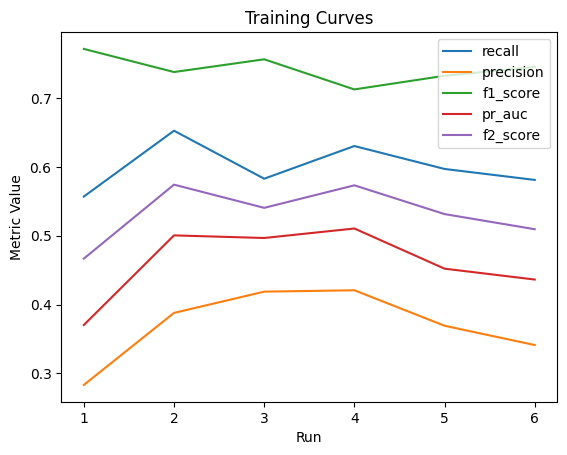

In [0]:
client = mlflow.MlflowClient()

experiment_id = client.get_experiment_by_name(f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_basic_wgraph").experiment_id
runs = client.search_runs(experiment_id)
df = pd.DataFrame([run.data.metrics for run in runs])
mean_metrics = df.mean()
print(mean_metrics)

# Plot training curves for each metric
metrics_to_plot = ['recall', 'precision', 'f1_score', 'pr_auc', 'f2_score']
for metric in metrics_to_plot:
    if metric in df.columns:
        plt.plot(df.index + 1, df[metric], label=metric)
plt.xlabel('Run')
plt.ylabel('Metric Value')
plt.title('Training Curves')
plt.legend()
plt.show()

f2_score     0.443887
f1_score     0.693944
recall       0.510425
precision    0.299090
pr_auc       0.313662
dtype: float64


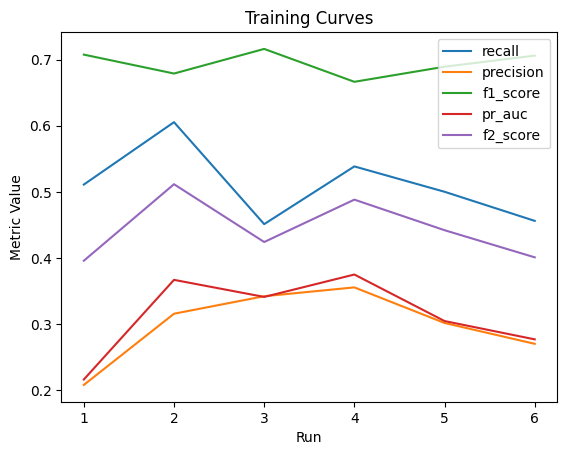

In [0]:
client = mlflow.MlflowClient()

experiment_id = client.get_experiment_by_name(f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_basic").experiment_id
runs = client.search_runs(experiment_id)
df = pd.DataFrame([run.data.metrics for run in runs])
mean_metrics = df.mean()
print(mean_metrics)

# Plot training curves for each metric
metrics_to_plot = ['recall', 'precision', 'f1_score', 'pr_auc', 'f2_score']
for metric in metrics_to_plot:
    if metric in df.columns:
        plt.plot(df.index + 1, df[metric], label=metric)
plt.xlabel('Run')
plt.ylabel('Metric Value')
plt.title('Training Curves')
plt.legend()
plt.show()


In [0]:

# temp_chart_path = "/tmp/mlflow_charts"
# if os.path.exists(temp_chart_path):
#     shutil.rmtree(temp_chart_path)
# os.makedirs(temp_chart_path)

# # --- Feature Importance Chart ---
# # Get the latest run/model
# if runs:
#     latest_run = runs[0]
#     latest_run_id = latest_run.info.run_id
#     model_uri = f"runs:/{latest_run_id}/basic_model"
    
#     try:
#         # 1. Load the feature name map from the artifact
#         temp_dir = mlflow.artifacts.download_artifacts(
#             run_id=latest_run_id, 
#             artifact_path="metadata/feature_names.json",
#             dst_path=temp_chart_path
#         )
#         feature_map_file = os.path.join(temp_dir, "metadata/feature_names.json")
#         with open(feature_map_file, 'r') as f:
#             final_feature_names_list = json.load(f)
        
#         # 2. Load the SparkXGBoostModel object
#         xgb_model_loaded = mlflow.spark.load_model(model_uri)
        
#         # --- FIX: Unwrap the model if it's encased in a PipelineModel wrapper ---
#         actual_xgb_model = xgb_model_loaded
#         if hasattr(xgb_model_loaded, 'stages') and len(xgb_model_loaded.stages) > 0:
#             # If it's a PipelineModel, the actual SparkXGBoostModel should be the first stage
#             actual_xgb_model = xgb_model_loaded.stages[0]
#         # ------------------------------------------------------------------------
            
#         # 3. Access the underlying booster model and get importance
#         booster = actual_xgb_model.get_booster()
#         importance = booster.get_score(importance_type='weight')
        
#         # 4. Convert to DataFrame and map indices to names
#         imp_df = pd.DataFrame(list(importance.items()), columns=['feature_index', 'importance'])
#         imp_df = imp_df.sort_values('importance', ascending=False)
        
#         # Extract the index number (e.g., 'f0' -> 0)
#         imp_df['feature_id'] = imp_df['feature_index'].str.replace('f', '').astype(int)
        
#         # Map the feature ID to the actual name
#         def map_feature_name(idx):
#             try:
#                 # Retrieve the feature name from the pre-logged list
#                 return final_feature_names_list[idx]
#             except IndexError:
#                 # Fallback for OHE features or if index is out of bounds
#                 return imp_df.loc[imp_df['feature_id'] == idx, 'feature_index'].iloc[0]
        
#         imp_df['feature'] = imp_df['feature_id'].apply(map_feature_name)
        
#         # 5. Plot using actual names
#         plt.figure(figsize=(10, len(imp_df) * 0.4 + 2)) 
#         # Use the actual feature names for the bar labels
#         plt.barh(imp_df['feature'], imp_df['importance'], color='#1f77b4')
#         plt.xlabel('Importance (Weight)')
#         plt.title(f'XGBoost Feature Importance (Run ID: {latest_run_id[:8]})')
#         plt.gca().invert_yaxis()
#         plt.tight_layout()
#         plt.show()
        
#         # 6. Log the plot as an artifact
#         chart_file = os.path.join(temp_chart_path, "feature_importance_chart.png")
#         plt.savefig(chart_file)
#         mlflow.client.MlflowClient().log_artifact(run_id=latest_run_id, local_path=chart_file, artifact_path="charts")
#         print(f"\nFeature importance chart saved to MLflow run: {latest_run_id}.")

#     except Exception as e:
#         print(f"Feature importance chart could not be generated: {e}")
#         print("\nCheck 1: Ensure the number of features in your DataFrame matches the number of indices (f0, f1, f2...) in the model.")
#         print("Check 2: Verify the logic in get_assembled_feature_names exactly matches the feature ordering from the pipeline model.")

#     # Clean up temporary chart directory
#     shutil.rmtree(temp_chart_path)

f2_score     0.442895
f1_score     0.699553
pr_auc       0.318814
precision    0.296072
recall       0.517160
dtype: float64


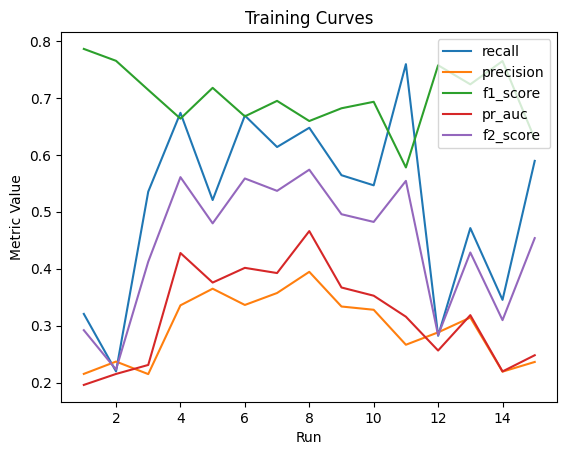

In [0]:
client = mlflow.MlflowClient()

experiment_id = client.get_experiment_by_name(f"/Workspace/Shared/Team_2_1/xgb/basic_xgboost_1y").experiment_id
runs = client.search_runs(experiment_id)
df = pd.DataFrame([run.data.metrics for run in runs])
mean_metrics = df.mean()
print(mean_metrics)

# Plot training curves for each metric
metrics_to_plot = ['recall', 'precision', 'f1_score', 'pr_auc', 'f2_score']
for metric in metrics_to_plot:
    if metric in df.columns:
        plt.plot(df.index + 1, df[metric], label=metric)
plt.xlabel('Run')
plt.ylabel('Metric Value')
plt.title('Training Curves')
plt.legend()
plt.show()


### 1Y GRID SEARCH

#### 6 param sets over 6 windows = 36 grid space

In [0]:
if use_grid_search is True:
    
    # Hyperparam Grid
    N_EST = [200]
    RATE = [0.01, 0.1]
    DEPTH = [5, 10, 15]

    experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gridsearch"

    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name,
            artifact_location="dbfs:/student-groups/Group_02_01/experiments/xgb"
        )
    except mlflow.exceptions.RestException:
        pass
        
    mlflow.set_experiment(experiment_name)

    target_col = "ARR_DEL15"

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="recallByLabel", 
        metricLabel=1
    )
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="precisionByLabel",
        metricLabel=1
    )
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="f1"
    )
    f2_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="fMeasureByLabel",
        metricLabel=1,
        beta=2.0
    )
    pr_auc_evaluator = BinaryClassificationEvaluator(
        labelCol=target_col, 
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR" 
    )
    log_loss_evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, 
    probabilityCol="probability", 
    metricName="logLoss"
    )

    for i in range(N):
        xgb_train_path = f"{input_path}/window_{i+1}_train"
        xgb_val_path = f"{input_path}/window_{i+1}_val"
        train_df = spark.read.parquet(xgb_train_path)
        val_df = spark.read.parquet(xgb_val_path)

        best_recall = -1.0
        best_params = {}
        best_model = None
        
        # Manual Grid Search
        with mlflow.start_run(run_name=f"xgb_window_{i+1}"):

            for n_est in N_EST:
                for rate in RATE:
                    for depth in DEPTH:
                        # Start a run for each parameter combination
                        with mlflow.start_run(run_name=f"n{n_est}_r{rate}_d{depth}", nested=True):
                            
                            xgb_classifier = SparkXGBClassifier(
                                features_col="full_unscaled_features", 
                                label_col=target_col, 
                                random_state=42, 
                                n_estimators=n_est, 
                                learning_rate=rate, 
                                max_depth=depth
                            )
                            
                            xgb_model = xgb_classifier.fit(train_df)
                            val_preds = xgb_model.transform(val_df)
                            
                            current_recall = recall_evaluator.evaluate(val_preds)
                            precision = precision_evaluator.evaluate(val_preds)
                            f1_score = f1_evaluator.evaluate(val_preds)
                            pr_auc = pr_auc_evaluator.evaluate(val_preds)
                            #f2_score = calculate_f2_score(precision, recall)
                            f2_score = f2_evaluator.evaluate(val_preds)
                            log_loss = log_loss_evaluator.evaluate(val_preds)
                            
                            # Log ALL parameters and the primary metric for this combination
                            mlflow.log_param("n_estimators", n_est)
                            mlflow.log_param("learning_rate", rate)
                            mlflow.log_param("max_depth", depth)
                            mlflow.log_param("window", i)
                            mlflow.log_metric("recall", current_recall)
                            mlflow.log_metric("precision", precision)
                            mlflow.log_metric("f1_score", f1_score)
                            mlflow.log_metric("f2_score", f2_score)
                            mlflow.log_metric("pr_auc", pr_auc)
                            mlflow.log_metric("log_loss", log_loss)

                            # Check for best model
                            if current_recall > best_recall:
                                best_recall = current_recall
                                best_params = {
                                    "n_estimators": n_est,
                                    "learning_rate": rate,
                                    "max_depth": depth
                                }
                                best_model = xgb_model
             
    # Log Best Model Results
    if best_model:
        val_preds_best = best_model.transform(val_df)
        
        # Evaluate ALL metrics using the best model
        recall = recall_evaluator.evaluate(val_preds_best) 
        precision = precision_evaluator.evaluate(val_preds_best)
        f1_score = f1_evaluator.evaluate(val_preds_best)
        pr_auc = pr_auc_evaluator.evaluate(val_preds_best)
        f2_score = f2_evaluator.evaluate(val_preds_best)
        log_loss = log_loss_evaluator.evaluate(val_preds_best)

        # Log best parameters and final metrics
        mlflow.log_param("window", i)
        mlflow.log_param("best_n_estimators", best_params["n_estimators"])
        mlflow.log_param("best_learning_rate", best_params["learning_rate"])
        mlflow.log_param("best_max_depth", best_params["max_depth"])
        
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("f1_score", f1_score)
        mlflow.log_metric("pr_auc", pr_auc)
        mlflow.log_metric("f2_score", f2_score)
        mlflow.log_metric("log_loss", log_loss)
        mlflow.spark.log_model(best_model, artifact_path="best_model")

        print(f"Window {i} complete. Best Params: {best_params}, Recall: {recall:.4f}")

2025-12-03 04:41:15,872 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-03 04:45:32,671 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!
2025-12-03 04:45:59,926 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 

Window 5 complete. Best Params: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 15}, Recall: 0.5971


In [0]:
client = mlflow.MlflowClient()

experiment_id = client.get_experiment_by_name(f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gridsearch").experiment_id
runs = client.search_runs(experiment_id)
df = pd.DataFrame([
    {
        **run.data.metrics,
        **run.data.params
    }
    for run in runs
])
group_cols = ['n_estimators', 'learning_rate', 'max_depth', ]
mean_metrics = df.groupby(group_cols)[['recall', 'precision', 'f1_score', 'pr_auc', 'f2_score', 'log_loss']].mean()
print(mean_metrics)

                                        recall  precision  ...  f2_score  log_loss
n_estimators learning_rate max_depth                       ...                    
200          0.01          10         0.640466   0.349445  ...  0.547806  0.584109
                           15         0.629005   0.358661  ...  0.545001  0.574040
                           5          0.655785   0.318836  ...  0.540563  0.606691
             0.1           10         0.588940   0.373466  ...  0.526233  0.551942
                           15         0.581867   0.367788  ...  0.519178  0.557497
                           5          0.603769   0.365121  ...  0.532995  0.561793

[6 rows x 6 columns]


In [0]:
mean_metrics = mean_metrics.reset_index()
display(mean_metrics)

n_estimators,learning_rate,max_depth,recall,precision,f1_score,pr_auc,f2_score,log_loss
200,0.01,10,0.6404657953062926,0.3494446425465938,0.7226646236783961,0.4567685047065823,0.547806215722608,0.5841093496706264
200,0.01,15,0.6290046690802159,0.358660748777136,0.7311335506253739,0.45933413709469195,0.5450006839566969,0.5740396871283189
200,0.01,5,0.6557850357943985,0.31883587249237927,0.6911243541658353,0.4369292289399442,0.5405632814055339,0.6066907920425844
200,0.1,10,0.5889402905812088,0.37346594416896167,0.7448001651740225,0.4591735216236836,0.5262332812853213,0.5519416712403433
200,0.1,15,0.5818668916158264,0.3677880763848517,0.7413734988201729,0.44985805437030474,0.5191778473485376,0.5574970073906239
200,0.1,5,0.6037687376226835,0.3651211187699009,0.7386967561970946,0.46012212281484294,0.5329954820778099,0.5617925346439864


In [0]:
if use_grid_search is True:
    
    N_EST = [200]
    RATE = [0.01]
    DEPTH = [10]
    SUBSAMPLE = [0.7, 0.9]
    COLSAMPLE_BYTREE = [0.9]

    experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gridsearch"

    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name,
            artifact_location="dbfs:/student-groups/Group_02_01/experiments/xgb"
        )
    except mlflow.exceptions.RestException:
        pass
        
    mlflow.set_experiment(experiment_name)

    target_col = "ARR_DEL15"

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="recallByLabel", 
        metricLabel=1
    )
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="precisionByLabel",
        metricLabel=1
    )
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="f1"
    )
    f2_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="fMeasureByLabel",
        metricLabel=1,
        beta=2.0
    )
    pr_auc_evaluator = BinaryClassificationEvaluator(
        labelCol=target_col, 
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR" 
    )
    log_loss_evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, 
    probabilityCol="probability", 
    metricName="logLoss"
    )

    for i in range(N):
        xgb_train_path = f"{input_path}/window_{i+1}_train"
        xgb_val_path = f"{input_path}/window_{i+1}_val"
        train_df = spark.read.parquet(xgb_train_path)
        val_df = spark.read.parquet(xgb_val_path)

        best_recall = -1.0
        best_params = {}
        best_model = None
        
        with mlflow.start_run(run_name=f"xgb_window_{i+1}_sample"):
            
            for n_est in N_EST:
                for rate in RATE:
                    for depth in DEPTH:
                        for subsample in SUBSAMPLE:
                            for colsample in COLSAMPLE_BYTREE:
                                run_name = f"n{n_est}_r{rate}_d{depth}_s{subsample}_c{colsample}"
                                with mlflow.start_run(run_name=run_name, nested=True):
                                    
                                    xgb_classifier = SparkXGBClassifier(
                                        features_col="full_unscaled_features", 
                                        label_col=target_col, 
                                        random_state=42, 
                                        n_estimators=n_est, 
                                        learning_rate=rate, 
                                        max_depth=depth,
                                        subsample=subsample,
                                        colsample_bytree=colsample
                                    )
                                    
                                    xgb_model = xgb_classifier.fit(train_df)
                                    val_preds = xgb_model.transform(val_df)
                                    
                                    current_recall = recall_evaluator.evaluate(val_preds)
                                    current_precision = precision_evaluator.evaluate(val_preds)
                                    current_f1_score = f1_evaluator.evaluate(val_preds)
                                    current_pr_auc = pr_auc_evaluator.evaluate(val_preds)
                                    current_f2_score = f2_evaluator.evaluate(val_preds)
                                    current_log_loss = log_loss_evaluator.evaluate(val_preds)

                                    mlflow.log_param("n_estimators", n_est)
                                    mlflow.log_param("learning_rate", rate)
                                    mlflow.log_param("max_depth", depth)
                                    mlflow.log_param("subsample", subsample)
                                    mlflow.log_param("colsample_bytree", colsample)
                                    
                                    mlflow.log_metric("recall", current_recall)
                                    mlflow.log_metric("precision", current_precision)
                                    mlflow.log_metric("f1_score", current_f1_score)
                                    mlflow.log_metric("pr_auc", current_pr_auc)
                                    mlflow.log_metric("f2_score", current_f2_score)
                                    mlflow.log_metric("log_loss", current_log_loss)
                                    
                                    if current_recall > best_recall:
                                        best_recall = current_recall
                                        best_params = {
                                            "n_estimators": n_est,
                                            "learning_rate": rate,
                                            "max_depth": depth,
                                            "subsample": subsample,
                                            "colsample_bytree": colsample
                                        }
                                        best_model = xgb_model
            
            if best_model:
                val_preds_best = best_model.transform(val_df)
                
                recall = recall_evaluator.evaluate(val_preds_best) 
                precision = precision_evaluator.evaluate(val_preds_best)
                f1_score = f1_evaluator.evaluate(val_preds_best)
                pr_auc = pr_auc_evaluator.evaluate(val_preds_best)
                f2_score = f2_evaluator.evaluate(val_preds_best)
                log_loss = log_loss_evaluator.evaluate(val_preds_best)

                mlflow.log_param("window", i)
                mlflow.log_param("best_n_estimators", best_params["n_estimators"])
                mlflow.log_param("best_learning_rate", best_params["learning_rate"])
                mlflow.log_param("best_max_depth", best_params["max_depth"])
                mlflow.log_param("best_subsample", best_params["subsample"])
                mlflow.log_param("best_colsample_bytree", best_params["colsample_bytree"])
                
                mlflow.log_metric("recall", recall)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("f1_score", f1_score)
                mlflow.log_metric("pr_auc", pr_auc)
                mlflow.log_metric("f2_score", f2_score)
                mlflow.log_metric("log_loss", log_loss)
                mlflow.spark.log_model(best_model, artifact_path="best_model")

                print(f"Window {i} complete. Best Params: {best_params}, Recall: {recall:.4f}")

2025-12-04 19:24:46,595 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 19:31:26,955 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-12-04 19:32:15,272 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 19:38:45,128 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025/12/04 19:40:33 WARNING mlflow.utils.environme

Window 0 complete. Best Params: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.9}, Recall: 0.6191


2025-12-04 19:40:38,000 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 19:47:21,588 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-12-04 19:48:03,046 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 19:54:57,885 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025/12/04 19:56:44 WARNING mlflow.utils.environme

Window 1 complete. Best Params: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.9}, Recall: 0.6414


2025-12-04 19:56:48,828 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 20:03:28,470 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-12-04 20:04:23,925 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 20:11:05,996 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025/12/04 20:13:07 WARNING mlflow.utils.environme

Window 2 complete. Best Params: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.9}, Recall: 0.6878


2025-12-04 20:13:10,877 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 20:20:43,214 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-12-04 20:21:21,273 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 20:29:03,836 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025/12/04 20:31:04 WARNING mlflow.utils.environme

Window 3 complete. Best Params: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.9}, Recall: 0.6230


2025-12-04 20:31:09,778 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 20:39:13,828 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-12-04 20:39:44,028 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 20:47:45,840 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025/12/04 20:49:33 WARNING mlflow.utils.environme

Window 4 complete. Best Params: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.9}, Recall: 0.6755


2025-12-04 20:49:37,731 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 20:57:48,126 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-12-04 20:58:17,428 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'subsample': 0.9, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 21:06:29,732 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025/12/04 21:08:07 WARNING mlflow.utils.environme

Window 5 complete. Best Params: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.9}, Recall: 0.5997


# Adding Regularization

In [0]:
if use_grid_search is True:
    
    N_EST = [200]
    RATE = [0.01]
    DEPTH = [5, 7]
    REG_ALPHA = [0.1, 1.0]
    REG_LAMBDA = [3.0, 10.0]
    COLSAMPLE_BYTREE = [0.9]

    # went with conservative number 0.7 and 0.9 since too much aggressiveness adds bias
    # subsample doesn't seem to add much value to model
    # colsample_bytree adds small improvements to the model
    # XGboost automatically uses lambda = 1.0 by default (L2 regularization)

    experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gridsearch"

    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name,
            artifact_location="dbfs:/student-groups/Group_02_01/experiments/xgb"
        )
    except mlflow.exceptions.RestException:
        pass
        
    mlflow.set_experiment(experiment_name)

    target_col = "ARR_DEL15"

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="recallByLabel", 
        metricLabel=1
    )
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="precisionByLabel",
        metricLabel=1
    )
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="f1"
    )
    f2_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="fMeasureByLabel",
        metricLabel=1,
        beta=2.0
    )
    pr_auc_evaluator = BinaryClassificationEvaluator(
        labelCol=target_col, 
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR" 
    )
    log_loss_evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, 
    probabilityCol="probability", 
    metricName="logLoss"
    )

    for i in range(N):
        xgb_train_path = f"{input_path}/window_{i+1}_train"
        xgb_val_path = f"{input_path}/window_{i+1}_val"
        train_df = spark.read.parquet(xgb_train_path)
        val_df = spark.read.parquet(xgb_val_path)

        best_recall = -1.0
        best_params = {}
        best_model = None
        
        with mlflow.start_run(run_name=f"xgb_window_{i+1}_reg2"):
            
            for n_est in N_EST:
                for rate in RATE:
                    for depth in DEPTH:
                        for reg_alpha in REG_ALPHA:
                            for reg_lambda in REG_LAMBDA:
                                for subsample in SUBSAMPLE:
                                    for colsample in COLSAMPLE_BYTREE:
                                        run_name = f"n{n_est}_r{rate}_d{depth}_a{reg_alpha}_l{reg_lambda}_s{subsample}_c{colsample}"
                                        with mlflow.start_run(run_name=run_name, nested=True):
                                            
                                            xgb_classifier = SparkXGBClassifier(
                                                features_col="full_unscaled_features", 
                                                label_col=target_col, 
                                                random_state=42, 
                                                n_estimators=n_est, 
                                                learning_rate=rate, 
                                                max_depth=depth,
                                                reg_alpha=reg_alpha,
                                                reg_lambda=reg_lambda,
                                                subsample=subsample,
                                                colsample_bytree=colsample
                                            )
                                            
                                            xgb_model = xgb_classifier.fit(train_df)
                                            train_preds = xgb_model.transform(train_df)
                                            val_preds = xgb_model.transform(val_df)
                                            
                                            # Train metrics
                                            train_recall = recall_evaluator.evaluate(train_preds) 
                                            train_precision = precision_evaluator.evaluate(train_preds)
                                            train_f1_score = f1_evaluator.evaluate(train_preds)
                                            train_pr_auc = pr_auc_evaluator.evaluate(train_preds)
                                            train_f2_score = f2_evaluator.evaluate(train_preds)
                                            train_log_loss = log_loss_evaluator.evaluate(train_preds)
                                            
                                            # Val metrics
                                            val_recall = recall_evaluator.evaluate(val_preds) 
                                            val_precision = precision_evaluator.evaluate(val_preds)
                                            val_f1_score = f1_evaluator.evaluate(val_preds)
                                            val_pr_auc = pr_auc_evaluator.evaluate(val_preds)
                                            val_f2_score = f2_evaluator.evaluate(val_preds)
                                            val_log_loss = log_loss_evaluator.evaluate(val_preds)

                                            # Log params
                                            mlflow.log_param("n_estimators", n_est)
                                            mlflow.log_param("learning_rate", rate)
                                            mlflow.log_param("max_depth", depth)
                                            mlflow.log_param("reg_alpha", reg_alpha)
                                            mlflow.log_param("reg_lambda", reg_lambda)
                                            mlflow.log_param("subsample", subsample)
                                            mlflow.log_param("colsample_bytree", colsample)
                                            
                                            # Log train metrics
                                            mlflow.log_metric("train_recall", train_recall)
                                            mlflow.log_metric("train_precision", train_precision)
                                            mlflow.log_metric("train_f1_score", train_f1_score)
                                            mlflow.log_metric("train_pr_auc", train_pr_auc)
                                            mlflow.log_metric("train_f2_score", train_f2_score)
                                            mlflow.log_metric("train_log_loss", train_log_loss)
                                            
                                            # Log val metrics
                                            mlflow.log_metric("val_recall", val_recall)
                                            mlflow.log_metric("val_precision", val_precision)
                                            mlflow.log_metric("val_f1_score", val_f1_score)
                                            mlflow.log_metric("val_pr_auc", val_pr_auc)
                                            mlflow.log_metric("val_f2_score", val_f2_score)
                                            mlflow.log_metric("val_log_loss", val_log_loss)
                                            
                                            if val_recall > best_recall:
                                                best_recall = val_recall
                                                best_params = {
                                                    "n_estimators": n_est,
                                                    "learning_rate": rate,
                                                    "max_depth": depth,
                                                    "reg_alpha": reg_alpha,
                                                    "reg_lambda": reg_lambda,
                                                    "subsample": subsample,
                                                    "colsample_bytree": colsample
                                                }
                                                best_model = xgb_model
            
            if best_model:
                val_preds_best = best_model.transform(val_df)
                train_preds_best = best_model.transform(train_df)
                
                recall = recall_evaluator.evaluate(val_preds_best) 
                precision = precision_evaluator.evaluate(val_preds_best)
                f1_score = f1_evaluator.evaluate(val_preds_best)
                pr_auc = pr_auc_evaluator.evaluate(val_preds_best)
                f2_score = f2_evaluator.evaluate(val_preds_best)
                log_loss = log_loss_evaluator.evaluate(val_preds_best)

                train_recall = recall_evaluator.evaluate(train_preds_best) 
                train_precision = precision_evaluator.evaluate(train_preds_best)
                train_f1_score = f1_evaluator.evaluate(train_preds_best)
                train_pr_auc = pr_auc_evaluator.evaluate(train_preds_best)
                train_f2_score = f2_evaluator.evaluate(train_preds_best)
                train_log_loss = log_loss_evaluator.evaluate(train_preds_best)

                mlflow.log_param("window", i+1)
                mlflow.log_param("best_n_estimators", best_params["n_estimators"])
                mlflow.log_param("best_learning_rate", best_params["learning_rate"])
                mlflow.log_param("best_max_depth", best_params["max_depth"])
                mlflow.log_param("best_reg_alpha", best_params["reg_alpha"])
                mlflow.log_param("best_reg_lambda", best_params["reg_lambda"])
                mlflow.log_param("best_subsample", best_params["subsample"])
                mlflow.log_param("best_colsample_bytree", best_params["colsample_bytree"])
                
                # Log best train metrics
                mlflow.log_metric("best_train_recall", train_recall)
                mlflow.log_metric("best_train_precision", train_precision)
                mlflow.log_metric("best_train_f1_score", train_f1_score)
                mlflow.log_metric("best_train_pr_auc", train_pr_auc)
                mlflow.log_metric("best_train_f2_score", train_f2_score)
                mlflow.log_metric("best_train_log_loss", train_log_loss)
                
                # Log best val metrics
                mlflow.log_metric("best_val_recall", recall)
                mlflow.log_metric("best_val_precision", precision)
                mlflow.log_metric("best_val_f1_score", f1_score)
                mlflow.log_metric("best_val_pr_auc", pr_auc)
                mlflow.log_metric("best_val_f2_score", f2_score)
                mlflow.log_metric("best_val_log_loss", log_loss)
                mlflow.spark.log_model(best_model, artifact_path="best_model")


2025-12-05 01:22:28,668 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 3.0, 'subsample': 0.7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 3.0, 'subsample': 0.7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-05 01:26:53,621 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!
2025-12-05 01:27:45,319 INFO XGBoost-P

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
client = mlflow.MlflowClient()

experiment_id = client.get_experiment_by_name(f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gridsearch").experiment_id
runs = client.search_runs(experiment_id)
df = pd.DataFrame([
    {
        **run.data.metrics,
        **run.data.params
    }
    for run in runs
])
group_cols = ['n_estimators', 'learning_rate', 'max_depth', 'reg_alpha', 'reg_lambda', 'subsample', 'colsample_bytree']
mean_metrics = df.groupby(group_cols).mean()
print(mean_metrics)

                                                                                      train_f1_score  ...  recall
n_estimators learning_rate max_depth reg_alpha reg_lambda subsample colsample_bytree                  ...        
200          0.01          10        0.01      1.0        0.7       0.9                     0.705254  ...     NaN
                                               5.0        0.7       0.9                     0.703304  ...     NaN
                           5         0.1       10.0       0.7       0.9                     0.657905  ...     NaN
                                               3.0        0.7       0.9                     0.658428  ...     NaN
                                     1.0       10.0       0.7       0.9                     0.657814  ...     NaN
                                               3.0        0.7       0.9                     0.658121  ...     NaN
                           7         0.1       10.0       0.7       0.9                 

/root/.ipykernel/1678/command-8173636742487983-194564053:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_metrics = df.groupby(group_cols).mean()


In [0]:
mean_metrics = mean_metrics.reset_index()
display(mean_metrics)

n_estimators,learning_rate,max_depth,reg_alpha,reg_lambda,subsample,colsample_bytree,train_f1_score,train_f2_score,train_log_loss,train_pr_auc,train_precision,train_recall,val_f1_score,val_f2_score,val_log_loss,val_pr_auc,val_precision,val_recall,best_train_f1_score,best_train_f2_score,best_train_log_loss,best_train_pr_auc,best_train_precision,best_train_recall,best_val_f1_score,best_val_f2_score,best_val_log_loss,best_val_pr_auc,best_val_precision,best_val_recall,f1_score,f2_score,log_loss,pr_auc,precision,recall
200,0.01,10,0.01,1.0,0.7,0.9,0.7052536127748708,0.7040830170596492,0.5793119411783163,0.7859890477137822,0.7057250419725718,0.703679699329442,0.7240008620563768,0.5483450219112224,0.5844553750512813,0.4600664578170028,0.3512631570503429,0.6401628711693667,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
200,0.01,10,0.01,5.0,0.7,0.9,0.7033035310350719,0.7019817838121641,0.5815464522797161,0.7822095698720372,0.7038576756003146,0.70152309998966,0.7238006497341333,0.5481223307087523,0.5847513447869652,0.459723668056961,0.3511192969232062,0.6400623325407754,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
200,0.01,5,0.1,10.0,0.7,0.9,0.6579046899793322,0.6668227144917555,0.6183513314990743,0.7306896547105848,0.6539218690468739,0.6701452003508434,0.6934991770146992,0.5298937086514732,0.6076659169405465,0.4267668338339591,0.31212249086706456,0.6420873980663167,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
200,0.01,5,0.1,3.0,0.7,0.9,0.6584278177867771,0.6679616646236786,0.6181499821618621,0.7310330066944238,0.6542256278610038,0.6715222812621606,0.6929971901308123,0.5308895068015591,0.6077412048469385,0.4273078215184192,0.31209062058138737,0.6441911196368919,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
200,0.01,5,1.0,10.0,0.7,0.9,0.657814357151389,0.6731244467058582,0.6196689456551859,0.728769430425618,0.6512892366802375,0.678813948504424,0.6974565444691802,0.5189321235386494,0.6039981323348012,0.4157700531120784,0.2969855115252191,0.6381617002220439,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
200,0.01,5,1.0,3.0,0.7,0.9,0.6581212798628849,0.666618376174418,0.6182247804893846,0.7309464022967542,0.6543195412650583,0.6697947090530285,0.6926672067066527,0.5303087822855923,0.6078646651852148,0.4272279899131485,0.3116519843802147,0.6435305354997258,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
200,0.01,7,0.1,10.0,0.7,0.9,0.6713496391154641,0.6739667890588031,0.6079902396589484,0.745796663625004,0.6697478174759877,0.6750298502893182,0.7112367673830905,0.5169527614534699,0.5955226616118962,0.42471258702403736,0.30764764700190306,0.6228985128654861,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
200,0.01,7,0.1,3.0,0.7,0.9,0.6720633813435558,0.6756438857207104,0.6073480852193914,0.7469484581989226,0.6700154817052295,0.6770657930992254,0.7115421653731228,0.5173260348998944,0.5949596578882558,0.42615250991106696,0.3080083366378635,0.623206388894072,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
200,0.01,7,1.0,10.0,0.7,0.9,0.6711530509109033,0.6744233515796833,0.6080349307465596,0.7456822082706335,0.669255190439948,0.6757278878241435,0.7104581043494997,0.5181874953626988,0.5957860030012204,0.4251529754947808,0.3072910937557291,0.6255107943201538,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
200,0.01,7,1.0,3.0,0.7,0.9,0.6721644459404508,0.6760571726702124,0.6074985583717231,0.7468098370250276,0.6699733007210622,0.6775954443866148,0.7106160758956975,0.5184937849072412,0.5952417276873131,0.42618255871203276,0.3075054206070163,0.625846659078611,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


# 1 YR FEATURE IMPORTANCE

In [0]:
# --- Function to extract feature names from VectorUDT metadata (Modified to RETURN the list) ---
def get_vector_feature_names(df, vector_col_name="model_features"):
    """
    Extracts the ordered list of feature names from a VectorUDT column's metadata.
    Returns: list of feature names.
    """
    feature_names = []
    try:
        vector_field = df.schema[vector_col_name]
        metadata = vector_field.metadata
        
        # Extract the list of features
        feature_names.extend(metadata.get('ml_attr', {}).get('attrs', {}).get('numeric', []))
        feature_names.extend(metadata.get('ml_attr', {}).get('attrs', {}).get('binary', []))
        
        # Handle OHE outputs, which are often nested under 'attributes'
        if 'attributes' in metadata.get('ml_attr', {}):
             feature_names.extend([
                 attr['name'] for attr in metadata['ml_attr']['attributes']
                 if 'name' in attr
             ])

        # Fallback extraction logic for different Spark versions/structures
        if not feature_names and metadata.get('ml_attr', {}).get('attrs', {}):
            for attr_list in metadata['ml_attr']['attrs'].values():
                feature_names.extend([attr['name'] for attr in attr_list if 'name' in attr])

        return feature_names

    except Exception as e:
        print(f"Error extracting metadata for {vector_col_name}: {e}")
        return []
# ---------------------------------------------------------------------------------------------

# --- NEW HELPER FUNCTION: Maps model indices to feature names ---
def map_indices_to_features(feature_names_list, indices_to_map):
    """
    Maps a list of integer indices (e.g., from feature importance) 
    to the corresponding feature names.
    
    Args:
        feature_names_list (list): The complete ordered list of feature names 
                                   (e.g., from get_vector_feature_names).
        indices_to_map (list): The indices to look up (e.g., [0, 17, 336]).

    Returns:
        dict: A dictionary mapping index -> feature name.
    """
    mapped_features = {}
    max_index = len(feature_names_list) - 1
    
    print("\n--- Feature Index Mapping ---")
    for index in indices_to_map:
        if 0 <= index <= max_index:
            name = feature_names_list[index]
            mapped_features[index] = name
            print(f"Index {index}: {name}")
        else:
            print(f"Index {index}: ERROR - Index out of bounds (Max Index: {max_index})")
    print("------------------------------\n")
    return mapped_features

In [0]:
train_path = f"{root}/fasw{time_length}/processed_rolling_windows/window_1_train"

train_df = spark.read.format("parquet").load(train_path)
scaled_names = get_vector_feature_names(train_df, "full_unscaled_features")
print(f"\n--- Features Assembled in 'model_features' (Total Length: {len(scaled_names)}) ---")
for name in scaled_names:
    print(f"- {name}")
print("--------------------------------------------------------------------------------\n")

# --- DIAGNOSTIC STEP: Example mapping using the user's specific indices ---
sample_indices_to_map = list(range(len(scaled_names)))


--- Features Assembled in 'model_features' (Total Length: 933) ---
- {'idx': 0, 'name': 'CRS_ELAPSED_TIME'}
- {'idx': 1, 'name': 'DEST_ELEVATION_FT'}
- {'idx': 2, 'name': 'DEST_LAT'}
- {'idx': 3, 'name': 'DEST_LON'}
- {'idx': 4, 'name': 'DISTANCE'}
- {'idx': 5, 'name': 'HourlyAltimeterSetting'}
- {'idx': 6, 'name': 'HourlyWindGustSpeed'}
- {'idx': 7, 'name': 'HourlyWindSpeed'}
- {'idx': 8, 'name': 'ORIGIN_ELEVATION_FT'}
- {'idx': 9, 'name': 'ORIGIN_LAT'}
- {'idx': 10, 'name': 'ORIGIN_LONG'}
- {'idx': 11, 'name': 'actual_to_crs_time_to_next_flight_diff_mins_clean'}
- {'idx': 12, 'name': 'crs_time_to_next_flight_diff_mins'}
- {'idx': 13, 'name': 'dest_in_degree'}
- {'idx': 14, 'name': 'dest_pagerank'}
- {'idx': 15, 'name': 'highest_cloud_ft'}
- {'idx': 16, 'name': 'lowest_cloud_ft'}
- {'idx': 17, 'name': 'origin_out_degree'}
- {'idx': 18, 'name': 'origin_pagerank'}
- {'idx': 19, 'name': 'overall_cloud_frac_0_1'}
- {'idx': 20, 'name': 'prev_flight_arr_delay_clean'}
- {'idx': 918, 'name':

In [0]:
# Extract idx and name from feature_names if each is a dict/object
feature_info = []
for item in scaled_names:
    if isinstance(item, dict) and "idx" in item and "name" in item:
        feature_info.append({"idx": item["idx"], "name": item["name"]})
    else:
        feature_info.append({"idx": None, "name": item})

# Convert to pandas DataFrame for ordering and display
feature_df = pd.DataFrame(feature_info)
feature_df_sorted = feature_df.sort_values(by="idx", ascending=True, na_position="last")

# Display all idx and name columns
display(feature_df_sorted[["idx", "name"]])

idx,name
0,CRS_ELAPSED_TIME
1,DEST_ELEVATION_FT
2,DEST_LAT
3,DEST_LON
4,DISTANCE
5,HourlyAltimeterSetting
6,HourlyWindGustSpeed
7,HourlyWindSpeed
8,ORIGIN_ELEVATION_FT
9,ORIGIN_LAT


In [0]:
experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gridsearch"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Experiment {experiment_name} not found.")

runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["start_time DESC"]
).to_dict(orient="records")

if runs:
    latest_run_id = runs[0]["run_id"]
    model_uri = f"runs:/{latest_run_id}/best_model"
    xgb_model_loaded = mlflow.spark.load_model(model_uri)
    actual_xgb_model = getattr(xgb_model_loaded, 'stages', [xgb_model_loaded])[0]
    booster = actual_xgb_model.get_booster()
    idx_to_name = dict(zip(feature_df_sorted['idx'], feature_df_sorted['name']))

    for imp_type in ["total_gain"]:
        importance = booster.get_score(importance_type=imp_type)
        if not importance:
            continue
        imp_df = pd.DataFrame(importance.items(), columns=['feature_index', imp_type])
        imp_df['feature_id'] = imp_df['feature_index'].str.extract(r'(\d+)').astype(int)
        imp_df['feature_name'] = imp_df['feature_id'].map(idx_to_name).fillna(imp_df['feature_index'])
        top_imp_df = imp_df.nlargest(75, imp_type)
        total_gain = imp_df[imp_type].sum()
        top_imp_df['feature_pct'] = top_imp_df[imp_type] / total_gain * 100
        top_imp_df['cumulative_pct'] = top_imp_df['feature_pct'].cumsum()
        print(f"\nTop features by {imp_type}:")
        display(top_imp_df[['feature_name', imp_type, 'feature_pct', 'cumulative_pct']])

        # plt.figure() #figsize=(10, 6)
        # plt.barh(top_imp_df['feature_name'], top_imp_df[imp_type])
        # plt.xlabel(f'Importance ({imp_type})')
        # plt.title(f'XGBoost Feature Importance ({imp_type})')
        # plt.gca().invert_yaxis()
        # plt.tight_layout()
        # plt.show()
else:
    print("No runs found in the experiment.")


Top features by total_gain:


feature_name,total_gain,feature_pct,cumulative_pct
actual_to_crs_time_to_next_flight_diff_mins_clean,3307202.75,22.75899244397664,22.75899244397664
crs_time_to_next_flight_diff_mins,2165416.75,14.90162750115954,37.66061994513618
HourlyAltimeterSetting,472549.75,3.251919220753264,40.91253916588945
ORIGIN_LONG,408140.40625,2.808677037392191,43.72121620328164
DEST_LON,384401.5625,2.6453147622686015,46.36653096555025
CRS_ELAPSED_TIME,346128.03125,2.3819299399975584,48.7484609055478
lowest_cloud_ft,280261.9375,1.9286629215268865,50.67712382707469
ohe_vector_CRS_DEP_TIME_BLOCK_ohe_0300-0359,260066.625,1.7896859674858177,52.466809794560504
origin_out_degree,241509.078125,1.6619795336704528,54.12878932823096
prev_flight_arr_delay_clean,237960.640625,1.6375604495213414,55.766349777752296


In [0]:
experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gridsearch"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Experiment {experiment_name} not found.")

runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["start_time DESC"]
).to_dict(orient="records")

if runs:
    latest_run_id = runs[0]["run_id"]
    model_uri = f"runs:/{latest_run_id}/best_model"
    xgb_model_loaded = mlflow.spark.load_model(model_uri)
    actual_xgb_model = getattr(xgb_model_loaded, 'stages', [xgb_model_loaded])[0]
    booster = actual_xgb_model.get_booster()
    idx_to_name = dict(zip(feature_df_sorted['idx'], feature_df_sorted['name']))

    for imp_type in ["gain"]:
        importance = booster.get_score(importance_type=imp_type)
        if not importance:
            continue
        imp_df = pd.DataFrame(importance.items(), columns=['feature_index', imp_type])
        imp_df['feature_id'] = imp_df['feature_index'].str.extract(r'(\d+)').astype(int)
        imp_df['feature_name'] = imp_df['feature_id'].map(idx_to_name).fillna(imp_df['feature_index'])
        top_imp_df = imp_df.nlargest(500, imp_type)
        total_gain = imp_df[imp_type].sum()
        top_imp_df['feature_pct'] = top_imp_df[imp_type] / total_gain * 100
        top_imp_df['cumulative_pct'] = top_imp_df['feature_pct'].cumsum()
        print(f"\nTop features by {imp_type}:")
        display(top_imp_df[['feature_name', imp_type, 'feature_pct', 'cumulative_pct']])

        # plt.figure() #figsize=(10, 6)
        # plt.barh(top_imp_df['feature_name'], top_imp_df[imp_type])
        # plt.xlabel(f'Importance ({imp_type})')
        # plt.title(f'XGBoost Feature Importance ({imp_type})')
        # plt.gca().invert_yaxis()
        # plt.tight_layout()
        # plt.show()
else:
    print("No runs found in the experiment.")


Top features by gain:


feature_name,gain,feature_pct,cumulative_pct
ohe_vector_ORIGIN_STATE_ABR_ohe_ND,234.64430236816406,4.50195264775906,4.50195264775906
ohe_vector_CRS_ARR_TIME_BLOCK_ohe_2300-2359,205.58578491210938,3.9444276267765455,8.446380274535606
ohe_vector_CRS_DEP_TIME_BLOCK_ohe_0100-0159,131.06414794921875,2.514634201347334,10.96101447588294
actual_to_crs_time_to_next_flight_diff_mins_clean,91.51593017578125,1.7558507920663275,12.716865267949268
ohe_vector_OP_UNIQUE_CARRIER_ohe_HA,90.99466705322266,1.7458496888172925,14.462714956766561
ohe_vector_CRS_DEP_TIME_BLOCK_ohe_0300-0359,90.11317443847656,1.7289371195757446,16.191652076342304
ohe_vector_CRS_DEP_TIME_BLOCK_ohe_0200-0259,89.0006103515625,1.7075911470277916,17.899243223370096
ohe_vector_CRS_ARR_TIME_BLOCK_ohe_1000-1059,66.5016098022461,1.275918892160928,19.175162115531023
ohe_vector_ORIGIN_ohe_HIB,48.244483947753906,0.9256324575381149,20.100794573069138
ohe_vector_CRS_ARR_TIME_BLOCK_ohe_1900-1959,45.28913497924805,0.8689302875747408,20.96972486064388



# 5 YEAR GRID SEARCH

In [0]:
## RUN TO BUILD FUNCTION FOR TIMEFRAME

from pyspark.sql import functions as F

root = "dbfs:/student-groups/Group_02_01"

def data_set(time):
    if time == 3:
        return "_3m"
    elif time == 6:
        return "_6m"
    elif time == 12:
        return "_1y"
    elif time == 'all':
        return ""
    else:
        raise ValueError("time must be 3, 6, 12, or 'all'")

#Checkpoint location
dbfs_path = "dbfs:/student-groups/Group_02_01"

#RUN FOR 1 YEAR
time = 'all' #12

# Define your existing paths
time_length = data_set(time)
input_path = f"{root}/fasw{time_length}/processed_rolling_windows"

In [0]:
%skip
test = spark.read.format("parquet").load("dbfs:/student-groups/Group_02_01/fasw/processed_train_test/test")
print(f"Count: {test.count()}")
display(test)
#7,271,711

df = spark.read.format("parquet").load("dbfs:/student-groups/Group_02_01/fasw/processed_rolling_windows/window_1_val")
print(f"Count: {df.count()}")
display(df)

#4,056,848
#5,572,019

In [0]:
import os
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql import functions
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, FeatureHasher, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from xgboost.spark import SparkXGBClassifier
import mlflow
import mlflow.spark
import matplotlib.pyplot as plt
import math

from datetime import date
from dateutil.relativedelta import relativedelta
from typing import List, Tuple

from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.sql.functions import log1p, when, sign, abs, col
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import math
from pyspark.sql.functions import skewness

In [0]:
%skip
# Target Variable
target_col = "ARR_DEL15"

# Numerical Cols (21 total - added 7 new)
num_cols = [
    "CRS_ELAPSED_TIME", "DISTANCE", 
    "ORIGIN_LAT", "ORIGIN_LONG", "ORIGIN_ELEVATION_FT", 
    "DEST_LAT", "DEST_LON", "DEST_ELEVATION_FT", 
    "overall_cloud_frac_0_1", "lowest_cloud_ft", "highest_cloud_ft", 
    "HourlyAltimeterSetting", "HourlyWindGustSpeed", "HourlyWindSpeed",
    # New graph features
    "origin_pagerank", "dest_pagerank", "origin_out_degree", "dest_in_degree",
    # New time-based features
    "prev_flight_arr_delay_clean", "crs_time_to_next_flight_diff_mins", 
    "actual_to_crs_time_to_next_flight_diff_mins_clean"
]
num_cols_sorted = sorted(num_cols)

# Cols to sign logscale (if skewed) - 12 total (added 4 new)
cols_to_logscale = [
    "CRS_ELAPSED_TIME", "DISTANCE", 
    "ORIGIN_ELEVATION_FT", "DEST_ELEVATION_FT", 
    "lowest_cloud_ft", "highest_cloud_ft", 
    "HourlyWindGustSpeed", "HourlyWindSpeed",
    # New columns that may be skewed
    "origin_out_degree", "dest_in_degree",
    "crs_time_to_next_flight_diff_mins", 
    "actual_to_crs_time_to_next_flight_diff_mins_clean"
]

# Numerical (Binary) Columns (15 total)
binary_cols = [
    "IS_US_HOLIDAY",
    "has_few", "has_sct", "has_bkn", "has_ovc", 
    "light", "heavy", "thunderstorm", "rain_or_drizzle",
    "freezing_conditions", "snow", "hail_or_ice", 
    "reduced_visibility", "spatial_effects", "unknown_precip"
]
# removing "CARRIER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY" for data leakage

# Categorical Columns (15 total)
cat_cols = [
    "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", 
    "DEST", "DEST_STATE_ABR", "ORIGIN_SIZE", "DEST_SIZE", 
    "HourlyWindCardinalDirection"
]

cyclical_cols = [
    "QUARTER", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", 
    "CRS_DEP_TIME_BLOCK", "CRS_ARR_TIME_BLOCK"
]
# removing "YEAR"
# not including high_cat_cols = ["TAIL_NUM"]

# Total feature columns: 51 (21 num + 15 binary + 15 cat)
# feature_cols = num_cols + binary_cols + cat_cols #+ high_cat_cols -- causing issues because of high cardinality

##### Prioritize features by importance of total gain

In [0]:
# Target Variable
target_col = "ARR_DEL15"

# Numerical Cols (20 total - added 7 new)
num_cols = [
    "CRS_ELAPSED_TIME", "DISTANCE", 
    "ORIGIN_LAT", "ORIGIN_LONG", "ORIGIN_ELEVATION_FT", 
    "DEST_LAT", "DEST_LON", "DEST_ELEVATION_FT", 
    "overall_cloud_frac_0_1", "lowest_cloud_ft",
    "HourlyAltimeterSetting", "HourlyWindGustSpeed", "HourlyWindSpeed",
    # New graph features
    "origin_pagerank", "dest_pagerank", "origin_out_degree", "dest_in_degree",
    # New time-based features
    "prev_flight_arr_delay_clean", "crs_time_to_next_flight_diff_mins", 
    "actual_to_crs_time_to_next_flight_diff_mins_clean"
]
num_cols_sorted = sorted(num_cols)

# Cols to sign logscale (if skewed) - 12 total (added 4 new)
cols_to_logscale = [
   "CRS_ELAPSED_TIME", "DISTANCE", 
    "ORIGIN_ELEVATION_FT", "DEST_ELEVATION_FT", 
    "lowest_cloud_ft", "highest_cloud_ft",
    "HourlyWindGustSpeed", "HourlyWindSpeed",
    # New columns that may be skewed
    "origin_out_degree", "dest_in_degree",
    "crs_time_to_next_flight_diff_mins", 
    "actual_to_crs_time_to_next_flight_diff_mins_clean"
]

# Numerical (Binary) Columns (8 total)
binary_cols = [
    "has_few", "has_sct", "has_bkn",
    "light", "heavy", "thunderstorm",
    "freezing_conditions", "snow"
]

# Categorical Columns (7 total)
cat_cols = [
    "OP_UNIQUE_CARRIER", "ORIGIN_STATE_ABR",
    "DEST"
]

cyclical_cols = [
    "DAY_OF_MONTH", "DAY_OF_WEEK", 
    "CRS_DEP_TIME_BLOCK", "CRS_ARR_TIME_BLOCK"
]

In [0]:
subdirs = [f for f in dbutils.fs.ls(f"{root}/fasw{time_length}/rolling_windows") if f.isDir()]
windows = len(subdirs)
N = int(windows / 2)
N

2

In [0]:
def downsample(train_df, target_ratio=1.0, verbose=False):
    '''Downsamples train_df to balance classes'''
    delay_count = train_df.filter(F.col("ARR_DEL15") == 1).count()
    non_delay_count = train_df.filter(F.col("ARR_DEL15") == 0).count()
    
    keep_percent = (delay_count / non_delay_count) / target_ratio

    if keep_percent >= 1.0:
        print("Warning: Target ratio is already balanced or majority is smaller. No sampling applied.")
        return train_df
    
    train_delay = train_df.filter(F.col('ARR_DEL15') == 1)
    train_non_delay = train_df.filter(F.col('ARR_DEL15') == 0).sample(withReplacement=False, fraction=keep_percent, seed=42)
    train_downsampled = train_delay.union(train_non_delay)
    return train_downsampled

In [0]:
# Directory / paths
input_path = f"{root}/fasw{time_length}/rolling_windows"
output_path = f"{root}/fasw{time_length}/xgb/processed_rolling_windows"

dbutils.fs.rm(output_path, True)
dbutils.fs.mkdirs(output_path)
display(f"Windows will be saved to: {output_path}")

# Sampling method
SAMPLING_METHOD = 'down'

### Get rolling window train and val files
for i in range(N):
    train_path = f"{input_path}/window_{i+1}_train"
    val_path = f"{input_path}/window_{i+1}_val"
    train_df = spark.read.parquet(train_path)
    val_df = spark.read.parquet(val_path)

    # Check if skewness is calculable and exceeds the threshold
    skew_row = train_df.agg(
        *[F.skewness(c).alias(c) for c in cols_to_logscale]
    ).first().asDict()

    log_scale = []
    log_output_cols = []
    cols_to_log_transform = []

    for col in cols_to_logscale:
        # Get skew value for the current column
        skew_value = skew_row.get(col) 

        # Check if skewness > 1.0 (highly skewed)
        if skew_value is not None and math.fabs(skew_value) > 1.0:
            new_col_name = f"{col}_log"
            
            # Signed log
            log_scale.append(
                (F.sign(F.col(col)) * F.log1p(F.abs(F.col(col)))).alias(new_col_name)
            )
            cols_to_log_transform.append(col)
            log_output_cols.append(new_col_name)

    if log_scale:
        train_df = train_df.select('*', *log_scale)
        val_df = val_df.select('*', *log_scale)
    
    # Remove cols that needed log transform
    cols_no_logscale = [col for col in num_cols if col not in cols_to_log_transform]

    # print(cols_no_logscale)
    # print(cols_to_log_transform)
    # print(num_cols)
    # print(log_output_cols)
    # print(ohe_output_cols)

    ### One-hot encode categorical columns
    ohe_stages = []
    ohe_output_cols = []
    # high cat cols (tail) causing issues
    for col in cat_cols + cyclical_cols:
        # indexing only applies to categorical
        indexer = StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
        encoder = OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe")
        ohe_stages.extend([indexer, encoder])
        ohe_output_cols.append(f"{col}_ohe")

    # Final features
    # final_features = cols_no_logscale + log_output_cols + ohe_output_cols + binary_cols #+ hash_output_cols -- this is causing too many issues
    num_features = cols_no_logscale + log_output_cols
    num_features = sorted(num_features)
    cat_features = ohe_output_cols + binary_cols

    for col in binary_cols:
        # Replace nulls with 0.0 and cast to DoubleType
        train_df = train_df.withColumn(col, F.when(F.col(col).isNull(), 0.0).otherwise(F.col(col)).cast(DoubleType()))
        val_df = val_df.withColumn(col, F.when(F.col(col).isNull(), 0.0).otherwise(F.col(col)).cast(DoubleType()))
    
    # 1 Numerical vector assembler
    numerical_assembler = VectorAssembler(
        inputCols=num_features, 
        outputCol="num_vector", 
        handleInvalid="keep"
    )
    
    # 2 Standard scaling ONLY the numerical features
    numerical_scaler = StandardScaler(
        inputCol="num_vector",
        outputCol="scaled_num_vector",
        withStd=True, 
        withMean=True
    )

    # 3 Categorical vector assembler
    categorical_assembler = VectorAssembler(
        inputCols=ohe_output_cols,
        outputCol="ohe_vector",
        handleInvalid="keep"
    )

    # 4a Combined vector merge: scaled numerical + categorical
    scaled_final_assembler = VectorAssembler(
        inputCols=["scaled_num_vector", "ohe_vector"] + binary_cols,
        outputCol="log_scaled_features", # final scaled feature vector
        handleInvalid="keep"
    )

    # 4b Combined vector merge: unscaled numerical + categorical
    unscaled_final_assembler = VectorAssembler(
        inputCols=["num_vector", "ohe_vector"] + binary_cols,
        outputCol="log_unscaled_features", # final unscaled feature vector
        handleInvalid="keep"
    )

    # 4c Combined vector merge: no log, unscaled numerical + categorical
    # Order matters - num_cols_sorted = num_features order (sorted)
    unscaled_final_assembler_no_log = VectorAssembler(
        inputCols= num_cols_sorted + ["ohe_vector"] + binary_cols,
        outputCol="full_unscaled_features", # final unscaled feature vector
        handleInvalid="keep"
    )

    stages = ohe_stages + [numerical_assembler, numerical_scaler, categorical_assembler, scaled_final_assembler, unscaled_final_assembler, unscaled_final_assembler_no_log]

    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(train_df)
    train_df = pipeline_model.transform(train_df)
    val_df = pipeline_model.transform(val_df)

    # Downsampling
    original_train_rows = train_df.count()
    train_df = downsample(train_df)
    new_train_rows = train_df.count()

    # Saving files
    train_path = f"{output_path}/window_{i+1}_train"
    val_path = f"{output_path}/window_{i+1}_val"
    dbutils.fs.rm(train_path, True)
    dbutils.fs.rm(val_path, True)
    
    train_df.write.format("parquet").mode("overwrite").save(train_path)
    print(f"\nWindows saved as parquet to: {train_path}. Row count: {new_train_rows} with {new_train_rows/original_train_rows * 100:.2f}% reduction")
    val_df.write.format("parquet").mode("overwrite").save(val_path)
    print(f"\nWindows saved as parquet to: {val_path}. Row count: {val_df.count()}")

'Windows will be saved to: dbfs:/student-groups/Group_02_01/fasw/xgb/processed_rolling_windows'


Windows saved as parquet to: dbfs:/student-groups/Group_02_01/fasw/xgb/processed_rolling_windows/window_1_train. Row count: 4054470 with 36.15% reduction

Windows saved as parquet to: dbfs:/student-groups/Group_02_01/fasw/xgb/processed_rolling_windows/window_1_val. Row count: 5572019

Windows saved as parquet to: dbfs:/student-groups/Group_02_01/fasw/xgb/processed_rolling_windows/window_2_train. Row count: 3986936 with 35.94% reduction

Windows saved as parquet to: dbfs:/student-groups/Group_02_01/fasw/xgb/processed_rolling_windows/window_2_val. Row count: 7086165


# Gridsearch CV

In [0]:
use_grid_search = True

In [0]:
if use_grid_search is True:
    
    # Hyperparam grid
    N_EST = [200, 250]
    RATE = [0.01]
    DEPTH = [5, 10]

    experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gridsearch"

    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name,
            artifact_location="dbfs:/student-groups/Group_02_01/experiments/xgb"
        )
    except mlflow.exceptions.RestException:
        pass
        
    mlflow.set_experiment(experiment_name)

    target_col = "ARR_DEL15"

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="recallByLabel", 
        metricLabel=1
    )
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="precisionByLabel",
        metricLabel=1
    )
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="f1"
    )
    f2_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="fMeasureByLabel",
        metricLabel=1,
        beta=2.0
    )
    pr_auc_evaluator = BinaryClassificationEvaluator(
        labelCol=target_col, 
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR" 
    )
    log_loss_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        probabilityCol="probability", 
        metricName="logLoss"
    )

    input_path = f"{root}/fasw{time_length}/xgb/processed_rolling_windows"

    for i in range(N):
        xgb_train_path = f"{input_path}/window_{i+1}_train"
        xgb_val_path = f"{input_path}/window_{i+1}_val"
        train_df = spark.read.parquet(xgb_train_path)
        val_df = spark.read.parquet(xgb_val_path)
        repart_train_df = train_df.repartition(192)

        best_recall = -1.0
        best_params = {}
        best_model = None
        
        with mlflow.start_run(run_name=f"xgb_window_{i+1}"):

            for n_est in N_EST:
                for rate in RATE:
                    for depth in DEPTH:
                        with mlflow.start_run(run_name=f"n{n_est}_r{rate}_d{depth}", nested=True):
                            
                            xgb_classifier = SparkXGBClassifier(
                                features_col="full_unscaled_features", 
                                label_col=target_col, 
                                random_state=42, 
                                n_estimators=n_est, 
                                learning_rate=rate, 
                                max_depth=depth
                            )
                            
                            xgb_model = xgb_classifier.fit(repart_train_df)
                            
                            # Train metrics
                            train_preds = xgb_model.transform(repart_train_df)
                            train_recall = recall_evaluator.evaluate(train_preds)
                            train_precision = precision_evaluator.evaluate(train_preds)
                            train_f1_score = f1_evaluator.evaluate(train_preds)
                            train_pr_auc = pr_auc_evaluator.evaluate(train_preds)
                            train_f2_score = f2_evaluator.evaluate(train_preds)
                            train_log_loss = log_loss_evaluator.evaluate(train_preds)

                            # Val metrics
                            val_preds = xgb_model.transform(val_df)
                            val_recall = recall_evaluator.evaluate(val_preds)
                            val_precision = precision_evaluator.evaluate(val_preds)
                            val_f1_score = f1_evaluator.evaluate(val_preds)
                            val_pr_auc = pr_auc_evaluator.evaluate(val_preds)
                            val_f2_score = f2_evaluator.evaluate(val_preds)
                            val_log_loss = log_loss_evaluator.evaluate(val_preds)
                            
                            mlflow.log_param("n_estimators", n_est)
                            mlflow.log_param("learning_rate", rate)
                            mlflow.log_param("max_depth", depth)
                            mlflow.log_param("window", i)
                            
                            # Log train metrics
                            mlflow.log_metric("train_recall", train_recall)
                            mlflow.log_metric("train_precision", train_precision)
                            mlflow.log_metric("train_f1_score", train_f1_score)
                            mlflow.log_metric("train_pr_auc", train_pr_auc)
                            mlflow.log_metric("train_f2_score", train_f2_score)
                            mlflow.log_metric("train_log_loss", train_log_loss)
                            
                            # Log val metrics
                            mlflow.log_metric("val_recall", val_recall)
                            mlflow.log_metric("val_precision", val_precision)
                            mlflow.log_metric("val_f1_score", val_f1_score)
                            mlflow.log_metric("val_pr_auc", val_pr_auc)
                            mlflow.log_metric("val_f2_score", val_f2_score)
                            mlflow.log_metric("val_log_loss", val_log_loss)

                            if val_recall > best_recall:
                                best_recall = val_recall
                                best_params = {
                                    "n_estimators": n_est,
                                    "learning_rate": rate,
                                    "max_depth": depth
                                }
                                best_model = xgb_model
             
    if best_model:
        val_preds_best = best_model.transform(val_df)
        recall = recall_evaluator.evaluate(val_preds_best) 
        precision = precision_evaluator.evaluate(val_preds_best)
        f1_score = f1_evaluator.evaluate(val_preds_best)
        pr_auc = pr_auc_evaluator.evaluate(val_preds_best)
        f2_score = f2_evaluator.evaluate(val_preds_best)
        log_loss = log_loss_evaluator.evaluate(val_preds_best)

        mlflow.log_param("window", i+1)
        mlflow.log_param("best_n_estimators", best_params["n_estimators"])
        mlflow.log_param("best_learning_rate", best_params["learning_rate"])
        mlflow.log_param("best_max_depth", best_params["max_depth"])
        
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("f1_score", f1_score)
        mlflow.log_metric("pr_auc", pr_auc)
        mlflow.log_metric("f2_score", f2_score)
        mlflow.log_metric("log_loss", log_loss)
        mlflow.spark.log_model(best_model, artifact_path="best_model")

        print(f"Window {i} complete. Best Params: {best_params}, Recall: {recall:.4f}")

2025-12-04 07:32:23,248 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 07:46:15,706 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-12-04 07:47:55,225 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'random_state': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-04 08:07:20,754 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-12-04 08:10:02,022 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logisti

Window 1 complete. Best Params: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 5}, Recall: 0.6856


In [0]:
# --- Function to extract feature names from VectorUDT metadata (Modified to RETURN the list) ---
def get_vector_feature_names(df, vector_col_name="model_features"):
    """
    Extracts the ordered list of feature names from a VectorUDT column's metadata.
    Returns: list of feature names.
    """
    feature_names = []
    try:
        vector_field = df.schema[vector_col_name]
        metadata = vector_field.metadata
        
        # Extract the list of features
        feature_names.extend(metadata.get('ml_attr', {}).get('attrs', {}).get('numeric', []))
        feature_names.extend(metadata.get('ml_attr', {}).get('attrs', {}).get('binary', []))
        
        # Handle OHE outputs, which are often nested under 'attributes'
        if 'attributes' in metadata.get('ml_attr', {}):
             feature_names.extend([
                 attr['name'] for attr in metadata['ml_attr']['attributes']
                 if 'name' in attr
             ])

        # Fallback extraction logic for different Spark versions/structures
        if not feature_names and metadata.get('ml_attr', {}).get('attrs', {}):
            for attr_list in metadata['ml_attr']['attrs'].values():
                feature_names.extend([attr['name'] for attr in attr_list if 'name' in attr])

        return feature_names

    except Exception as e:
        print(f"Error extracting metadata for {vector_col_name}: {e}")
        return []
# ---------------------------------------------------------------------------------------------

# --- NEW HELPER FUNCTION: Maps model indices to feature names ---
def map_indices_to_features(feature_names_list, indices_to_map):
    """
    Maps a list of integer indices (e.g., from feature importance) 
    to the corresponding feature names.
    
    Args:
        feature_names_list (list): The complete ordered list of feature names 
                                   (e.g., from get_vector_feature_names).
        indices_to_map (list): The indices to look up (e.g., [0, 17, 336]).

    Returns:
        dict: A dictionary mapping index -> feature name.
    """
    mapped_features = {}
    max_index = len(feature_names_list) - 1
    
    print("\n--- Feature Index Mapping ---")
    for index in indices_to_map:
        if 0 <= index <= max_index:
            name = feature_names_list[index]
            mapped_features[index] = name
            print(f"Index {index}: {name}")
        else:
            print(f"Index {index}: ERROR - Index out of bounds (Max Index: {max_index})")
    print("------------------------------\n")
    return mapped_features


train_path = f"{root}/fasw{time_length}/processed_rolling_windows/window_1_train"

train_df = spark.read.format("parquet").load(train_path)
scaled_names = get_vector_feature_names(train_df, "full_unscaled_features")
print(f"\n--- Features Assembled in 'model_features' (Total Length: {len(scaled_names)}) ---")
for name in scaled_names:
    print(f"- {name}")
print("--------------------------------------------------------------------------------\n")

# --- DIAGNOSTIC STEP: Example mapping using the user's specific indices ---
sample_indices_to_map = list(range(len(scaled_names)))

# Extract idx and name from feature_names if each is a dict/object
feature_info = []
for item in scaled_names:
    if isinstance(item, dict) and "idx" in item and "name" in item:
        feature_info.append({"idx": item["idx"], "name": item["name"]})
    else:
        feature_info.append({"idx": None, "name": item})

# Convert to pandas DataFrame for ordering and display
feature_df = pd.DataFrame(feature_info)
feature_df_sorted = feature_df.sort_values(by="idx", ascending=True, na_position="last")

# Display all idx and name columns
display(feature_df_sorted[["idx", "name"]])


--- Features Assembled in 'model_features' (Total Length: 899) ---
- {'idx': 0, 'name': 'CRS_ELAPSED_TIME'}
- {'idx': 1, 'name': 'DEST_ELEVATION_FT'}
- {'idx': 2, 'name': 'DEST_LAT'}
- {'idx': 3, 'name': 'DEST_LON'}
- {'idx': 4, 'name': 'DISTANCE'}
- {'idx': 5, 'name': 'HourlyAltimeterSetting'}
- {'idx': 6, 'name': 'HourlyWindGustSpeed'}
- {'idx': 7, 'name': 'HourlyWindSpeed'}
- {'idx': 8, 'name': 'ORIGIN_ELEVATION_FT'}
- {'idx': 9, 'name': 'ORIGIN_LAT'}
- {'idx': 10, 'name': 'ORIGIN_LONG'}
- {'idx': 11, 'name': 'actual_to_crs_time_to_next_flight_diff_mins_clean'}
- {'idx': 12, 'name': 'crs_time_to_next_flight_diff_mins'}
- {'idx': 13, 'name': 'dest_in_degree'}
- {'idx': 14, 'name': 'dest_pagerank'}
- {'idx': 15, 'name': 'highest_cloud_ft'}
- {'idx': 16, 'name': 'lowest_cloud_ft'}
- {'idx': 17, 'name': 'origin_out_degree'}
- {'idx': 18, 'name': 'origin_pagerank'}
- {'idx': 19, 'name': 'overall_cloud_frac_0_1'}
- {'idx': 20, 'name': 'prev_flight_arr_delay_clean'}
- {'idx': 884, 'name':

idx,name
0,CRS_ELAPSED_TIME
1,DEST_ELEVATION_FT
2,DEST_LAT
3,DEST_LON
4,DISTANCE
5,HourlyAltimeterSetting
6,HourlyWindGustSpeed
7,HourlyWindSpeed
8,ORIGIN_ELEVATION_FT
9,ORIGIN_LAT


In [0]:
experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost_manual_gridsearch"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Experiment {experiment_name} not found.")

runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["start_time DESC"]
).to_dict(orient="records")

display(runs)

artifact_uri,end_time,experiment_id,metrics.f2_score,metrics.pr_auc,metrics.precision,metrics.recall,params.OneHotEncoder_1.dropLast,params.OneHotEncoder_1.handleInvalid,params.OneHotEncoder_1.inputCol,params.OneHotEncoder_1.outputCol,params.OneHotEncoder_2.dropLast,params.OneHotEncoder_2.handleInvalid,params.OneHotEncoder_2.inputCol,params.OneHotEncoder_2.outputCol,params.OneHotEncoder_3.dropLast,params.OneHotEncoder_3.handleInvalid,params.OneHotEncoder_3.inputCol,params.OneHotEncoder_3.outputCol,params.OneHotEncoder_4.dropLast,params.OneHotEncoder_4.handleInvalid,params.OneHotEncoder_4.inputCol,params.OneHotEncoder_4.outputCol,params.OneHotEncoder_5.dropLast,params.OneHotEncoder_5.handleInvalid,params.OneHotEncoder_5.inputCol,params.OneHotEncoder_5.outputCol,params.OneHotEncoder_6.dropLast,params.OneHotEncoder_6.handleInvalid,params.OneHotEncoder_6.inputCol,params.OneHotEncoder_6.outputCol,params.OneHotEncoder_7.dropLast,params.OneHotEncoder_7.handleInvalid,params.OneHotEncoder_7.inputCol,params.OneHotEncoder_7.outputCol,params.StandardScaler.inputCol,params.StandardScaler.outputCol,params.StandardScaler.withMean,params.StandardScaler.withStd,params.StringIndexer_1.handleInvalid,params.StringIndexer_1.inputCol,params.StringIndexer_1.outputCol,params.StringIndexer_1.stringOrderType,params.StringIndexer_2.handleInvalid,params.StringIndexer_2.inputCol,params.StringIndexer_2.outputCol,params.StringIndexer_2.stringOrderType,params.StringIndexer_3.handleInvalid,params.StringIndexer_3.inputCol,params.StringIndexer_3.outputCol,params.StringIndexer_3.stringOrderType,params.StringIndexer_4.handleInvalid,params.StringIndexer_4.inputCol,params.StringIndexer_4.outputCol,params.StringIndexer_4.stringOrderType,params.StringIndexer_5.handleInvalid,params.StringIndexer_5.inputCol,params.StringIndexer_5.outputCol,params.StringIndexer_5.stringOrderType,params.StringIndexer_6.handleInvalid,params.StringIndexer_6.inputCol,params.StringIndexer_6.outputCol,params.StringIndexer_6.stringOrderType,params.StringIndexer_7.handleInvalid,params.StringIndexer_7.inputCol,params.StringIndexer_7.outputCol,params.StringIndexer_7.stringOrderType,params.VectorAssembler_1.handleInvalid,params.VectorAssembler_1.inputCols,params.VectorAssembler_1.outputCol,params.VectorAssembler_2.handleInvalid,params.VectorAssembler_2.inputCols,params.VectorAssembler_2.outputCol,params.VectorAssembler_3.handleInvalid,params.VectorAssembler_3.inputCols,params.VectorAssembler_3.outputCol,params.VectorAssembler_4.handleInvalid,params.VectorAssembler_4.inputCols,params.VectorAssembler_4.outputCol,params.VectorAssembler_5.handleInvalid,params.VectorAssembler_5.inputCols,params.VectorAssembler_5.outputCol,params.best_learning_rate,params.best_max_depth,params.best_n_estimators,params.learning_rate,params.max_depth,params.n_estimators,params.stages,params.window,run_id,start_time,status,tags.estimator_class,tags.estimator_name,tags.mlflow.autologging,tags.mlflow.databricks.cluster.id,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.cluster.libraries,tags.mlflow.databricks.notebook.commandID,tags.mlflow.databricks.notebookID,tags.mlflow.databricks.notebookPath,tags.mlflow.databricks.notebookRevisionError,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.workspaceID,tags.mlflow.databricks.workspaceURL,tags.mlflow.log-model.history,tags.mlflow.parentRunId,tags.mlflow.rootRunId,tags.mlflow.runColor,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.sparkDatasourceInfo
dbfs:/student-groups/Group_02_01/experiments/xgb/6138b3335cf84557a4a565f331b3b7c1/artifacts,List(),3915201981341443,NaN,NaN,NaN,NaN,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,

In [0]:
experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost_manual_gridsearch"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Experiment {experiment_name} not found.")

runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["start_time DESC"]
).to_dict(orient="records")

model_found = False
for run in runs:
    run_id = run["run_id"]
    model_uri = f"runs:/{run_id}/best_model"
    try:
        xgb_model_loaded = mlflow.spark.load_model(model_uri)
        actual_xgb_model = getattr(xgb_model_loaded, 'stages', [xgb_model_loaded])[0]
        booster = actual_xgb_model.get_booster()
        idx_to_name = dict(zip(feature_df_sorted['idx'], feature_df_sorted['name']))

        for imp_type in ["total_gain"]:
            importance = booster.get_score(importance_type=imp_type)
            if not importance:
                continue
            imp_df = pd.DataFrame(importance.items(), columns=['feature_index', imp_type])
            imp_df['feature_id'] = imp_df['feature_index'].str.extract(r'(\d+)').astype(int)
            imp_df['feature_name'] = imp_df['feature_id'].map(idx_to_name).fillna(imp_df['feature_index'])
            top_imp_df = imp_df.nlargest(75, imp_type)
            total_gain = imp_df[imp_type].sum()
            top_imp_df['feature_pct'] = top_imp_df[imp_type] / total_gain * 100
            top_imp_df['cumulative_pct'] = top_imp_df['feature_pct'].cumsum()
            print(f"\nTop features by {imp_type}:")
            display(top_imp_df[['feature_name', imp_type, 'feature_pct', 'cumulative_pct']])
        model_found = True
        break
    except Exception as e:
        continue

if not model_found:
    print("No runs with a valid model found in the experiment.")


Top features by total_gain:


feature_name,total_gain,feature_pct,cumulative_pct
actual_to_crs_time_to_next_flight_diff_mins_clean,1.3101877E7,49.045564764936074,49.045564764936074
crs_time_to_next_flight_diff_mins,5742224.0,21.495440621734602,70.54100538667068
DEST_ELEVATION_FT,921300.4375,3.4487959454488992,73.98980133211957
overall_cloud_frac_0_1,854822.875,3.199943846088721,77.18974517820828
HourlyAltimeterSetting,653144.1875,2.44497987188193,79.63472505009021
lowest_cloud_ft,499980.125,1.8716255389871495,81.50635058907736
dest_in_degree,428979.40625,1.6058414570720054,83.11219204614936
ohe_vector_DEST_ohe_AUS,389237.25,1.4570706742095512,84.5692627203589
ohe_vector_OP_UNIQUE_CARRIER_ohe_WN,354862.71875,1.328393058117888,85.89765577847679
DEST_LON,295371.15625,1.1056923503062521,87.00334812878305


# FINAL TRAIN/TEST

##### Prioritize features with most importance in total gain

In [0]:
# Target Variable
target_col = "ARR_DEL15"

# Numerical Cols (20 total - added 7 new)
num_cols = [
    "CRS_ELAPSED_TIME", "DEST_LON", "DEST_ELEVATION_FT", 
    "overall_cloud_frac_0_1", "lowest_cloud_ft",
    "HourlyAltimeterSetting",
    # New graph features
    "dest_in_degree",
    # New time-based features
    "crs_time_to_next_flight_diff_mins", 
    "actual_to_crs_time_to_next_flight_diff_mins_clean"
]
num_cols_sorted = sorted(num_cols)

# Cols to sign logscale (if skewed) - 12 total (added 4 new)
cols_to_logscale = [
   "CRS_ELAPSED_TIME", "DEST_ELEVATION_FT", 
    "lowest_cloud_ft",
    # New columns that may be skewed
    "dest_in_degree",
    "crs_time_to_next_flight_diff_mins", 
    "actual_to_crs_time_to_next_flight_diff_mins_clean"
]

# Numerical (Binary) Columns (8 total)
binary_cols = [
]

# Categorical Columns (7 total)
cat_cols = [
    "OP_UNIQUE_CARRIER", "ORIGIN",
    "DEST"
]

cyclical_cols = [
]

In [0]:
input_path = f"{root}/fasw{time_length}/train_test"
output_path = f"{root}/fasw{time_length}/xgb"

# Sampling method
SAMPLING_METHOD = 'down'

train_path = f"{input_path}/split=train"
test_path = f"{input_path}/split=test"
train_df = spark.read.parquet(train_path)
test_df = spark.read.parquet(test_path)

# Check if skewness is calculable and exceeds the threshold
skew_row = train_df.agg(
    *[F.skewness(c).alias(c) for c in cols_to_logscale]
).first().asDict()

log_scale = []
log_output_cols = []
cols_to_log_transform = []

for col in cols_to_logscale:
    # Get skew value for the current column
    skew_value = skew_row.get(col) 

    # Check if skewness > 1.0 (highly skewed)
    if skew_value is not None and math.fabs(skew_value) > 1.0:
        new_col_name = f"{col}_log"
        
        # Signed log
        log_scale.append(
            (F.sign(F.col(col)) * F.log1p(F.abs(F.col(col)))).alias(new_col_name)
        )
        cols_to_log_transform.append(col)
        log_output_cols.append(new_col_name)

if log_scale:
    train_df = train_df.select('*', *log_scale)
    test_df = test_df.select('*', *log_scale)

# Remove cols that needed log transform
cols_no_logscale = [col for col in num_cols if col not in cols_to_log_transform]

# print(cols_no_logscale)
# print(cols_to_log_transform)
# print(num_cols)
# print(log_output_cols)
# print(ohe_output_cols)

### One-hot encode categorical columns
ohe_stages = []
ohe_output_cols = []
# high cat cols (tail) causing issues
for col in cat_cols + cyclical_cols:
    # indexing only applies to categorical
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    encoder = OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe")
    ohe_stages.extend([indexer, encoder])
    ohe_output_cols.append(f"{col}_ohe")

# Final features
# final_features = cols_no_logscale + log_output_cols + ohe_output_cols + binary_cols #+ hash_output_cols -- this is causing too many issues
num_features = cols_no_logscale + log_output_cols
num_features = sorted(num_features)
cat_features = ohe_output_cols + binary_cols

for col in binary_cols:
    # Replace nulls with 0.0 and cast to DoubleType
    train_df = train_df.withColumn(col, F.when(F.col(col).isNull(), 0.0).otherwise(F.col(col)).cast(DoubleType()))
    test_df = test_df.withColumn(col, F.when(F.col(col).isNull(), 0.0).otherwise(F.col(col)).cast(DoubleType()))

# 1 Numerical vector assembler
numerical_assembler = VectorAssembler(
    inputCols=num_features, 
    outputCol="num_vector", 
    handleInvalid="keep"
)

# 2 Standard scaling ONLY the numerical features
numerical_scaler = StandardScaler(
    inputCol="num_vector",
    outputCol="scaled_num_vector",
    withStd=True, 
    withMean=True
)

# 3 Categorical vector assembler
categorical_assembler = VectorAssembler(
    inputCols=ohe_output_cols,
    outputCol="ohe_vector",
    handleInvalid="keep"
)

# 4a Combined vector merge: scaled numerical + categorical
scaled_final_assembler = VectorAssembler(
    inputCols=["scaled_num_vector", "ohe_vector"] + binary_cols,
    outputCol="log_scaled_features", # final scaled feature vector
    handleInvalid="keep"
)

# 4b Combined vector merge: unscaled numerical + categorical
unscaled_final_assembler = VectorAssembler(
    inputCols=["num_vector", "ohe_vector"] + binary_cols,
    outputCol="log_unscaled_features", # final unscaled feature vector
    handleInvalid="keep"
)

# 4c Combined vector merge: no log, unscaled numerical + categorical
# Order matters - num_cols_sorted = num_features order (sorted)
unscaled_final_assembler_no_log = VectorAssembler(
    inputCols= num_cols_sorted + ["ohe_vector"] + binary_cols,
    outputCol="full_unscaled_features", # final unscaled feature vector
    handleInvalid="keep"
)

stages = ohe_stages + [numerical_assembler, numerical_scaler, categorical_assembler, scaled_final_assembler, unscaled_final_assembler, unscaled_final_assembler_no_log]

pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(train_df)
train_df = pipeline_model.transform(train_df)
test_df = pipeline_model.transform(test_df)

# Downsampling
original_train_rows = train_df.count()
train_df = downsample(train_df)
new_train_rows = train_df.count()

# Saving files
train_path = f"{output_path}/train"
test_path = f"{output_path}/test"
dbutils.fs.rm(train_path, True)
dbutils.fs.rm(test_path, True)

train_df.write.format("parquet").mode("overwrite").save(train_path)
print(f"\nWindows saved as parquet to: {train_path}. Row count: {new_train_rows} with {new_train_rows/original_train_rows * 100:.2f}% reduction")
test_df.write.format("parquet").mode("overwrite").save(test_path)
print(f"\nWindows saved as parquet to: {test_path}. Row count: {test_df.count()}")


Windows saved as parquet to: dbfs:/student-groups/Group_02_01/fasw/xgb/train. Row count: 8812137 with 36.91% reduction

Windows saved as parquet to: dbfs:/student-groups/Group_02_01/fasw/xgb/test. Row count: 7271711


In [0]:
def downsample(train_df, target_ratio=1.0, verbose=False):
    '''Downsamples train_df to balance classes'''
    delay_count = train_df.filter(F.col("ARR_DEL15") == 1).count()
    non_delay_count = train_df.filter(F.col("ARR_DEL15") == 0).count()
    
    keep_percent = (delay_count / non_delay_count) / target_ratio

    if keep_percent >= 1.0:
        print("Warning: Target ratio is already balanced or majority is smaller. No sampling applied.")
        return train_df
    
    train_delay = train_df.filter(F.col('ARR_DEL15') == 1)
    train_non_delay = train_df.filter(F.col('ARR_DEL15') == 0).sample(withReplacement=False, fraction=keep_percent, seed=42)
    train_downsampled = train_delay.union(train_non_delay)
    return train_downsampled

In [0]:
use_grid_search = True
if use_grid_search is True:
    
    N_EST = 200
    RATE = 0.01
    DEPTH = 10
    COLSAMPLE_BYTREE = 0.9

    # went with conservative number 0.7 and 0.9 since too much aggressiveness adds bias
    # subsample doesn't seem to add much value to model
    # colsample_bytree adds small improvements to the model
    # XGboost automatically uses lambda = 1.0 by default (L2 regularization)
    # L1 regularization is a little excessive, doesn't contribute much but brings precision slightly down without boosting recall much

    experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gridsearch"

    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name,
            artifact_location="dbfs:/student-groups/Group_02_01/experiments/xgb"
        )
    except mlflow.exceptions.RestException:
        pass
        
    mlflow.set_experiment(experiment_name)

    target_col = "ARR_DEL15"

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="recallByLabel", 
        metricLabel=1
    )
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="precisionByLabel",
        metricLabel=1
    )
    # f1_evaluator = MulticlassClassificationEvaluator(
    #     labelCol=target_col, 
    #     predictionCol="prediction", 
    #     metricName="f1"
    # )
    f2_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="fMeasureByLabel",
        metricLabel=1,
        beta=2.0
    )
    pr_auc_evaluator = BinaryClassificationEvaluator(
        labelCol=target_col, 
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR" 
    )
    # log_loss_evaluator = MulticlassClassificationEvaluator(
    # labelCol=target_col, 
    # probabilityCol="probability", 
    # metricName="logLoss"
    # )

    xgb_train_path = "dbfs:/student-groups/Group_02_01/fasw/xgb/train"
    xgb_test_path = "dbfs:/student-groups/Group_02_01/fasw/xgb/test"
    train_df = spark.read.parquet(xgb_train_path)
    test_df = spark.read.parquet(xgb_test_path)

    NUM_PARTITIONS = 512 # 12 workers x 16 cores x 3
    train_df = spark.read.parquet(xgb_train_path).repartition(NUM_PARTITIONS)
    test_df = spark.read.parquet(xgb_test_path).repartition(NUM_PARTITIONS)

    best_recall = -1.0
    best_params = {}
    best_model = None
    
    with mlflow.start_run(run_name=f"xgb_final"):
        
        run_name = f"n{N_EST}_r{RATE}_d{DEPTH}_c{COLSAMPLE_BYTREE}"
        with mlflow.start_run(run_name=run_name, nested=True):
            
            xgb_classifier = SparkXGBClassifier(
                features_col="full_unscaled_features", 
                label_col=target_col, 
                random_state=42, 
                n_estimators=N_EST, 
                learning_rate=RATE, 
                max_depth=DEPTH,
                colsample_bytree=COLSAMPLE_BYTREE,
                tree_method="hist", # used automatically though
                max_bin=128,
                num_workers=12
            )
            
            xgb_model = xgb_classifier.fit(train_df)
            train_preds = xgb_model.transform(train_df).cache()
            test_preds = xgb_model.transform(test_df).cache()

            train_preds.count()
            test_preds.count()
            
            # Train metrics
            train_recall = recall_evaluator.evaluate(train_preds) 
            train_precision = precision_evaluator.evaluate(train_preds)
            # train_f1_score = f1_evaluator.evaluate(train_preds)
            train_pr_auc = pr_auc_evaluator.evaluate(train_preds)
            train_f2_score = f2_evaluator.evaluate(train_preds)
            # train_log_loss = log_loss_evaluator.evaluate(train_preds)
            
            # Val metrics
            test_recall = recall_evaluator.evaluate(test_preds) 
            test_precision = precision_evaluator.evaluate(test_preds)
            # test_f1_score = f1_evaluator.evaluate(test_preds)
            test_pr_auc = pr_auc_evaluator.evaluate(test_preds)
            test_f2_score = f2_evaluator.evaluate(test_preds)
            # test_log_loss = log_loss_evaluator.evaluate(test_preds)

            # Log params
            mlflow.log_param("n_estimators", N_EST)
            mlflow.log_param("learning_rate", RATE)
            mlflow.log_param("max_depth", DEPTH)
            mlflow.log_param("colsample_bytree", COLSAMPLE_BYTREE)
            
            # Log train metrics
            mlflow.log_metric("train_recall", train_recall)
            mlflow.log_metric("train_precision", train_precision)
            # mlflow.log_metric("train_f1_score", train_f1_score)
            mlflow.log_metric("train_pr_auc", train_pr_auc)
            mlflow.log_metric("train_f2_score", train_f2_score)
            # mlflow.log_metric("train_log_loss", train_log_loss)
            
            # Log val metrics
            mlflow.log_metric("test_recall", test_recall)
            mlflow.log_metric("test_precision", test_precision)
            # mlflow.log_metric("test_f1_score", test_f1_score)
            mlflow.log_metric("test_pr_auc", test_pr_auc)
            mlflow.log_metric("test_f2_score", test_f2_score)
            # mlflow.log_metric("test_log_loss", test_log_loss)

            train_preds.unpersist()
            test_preds.unpersist()


2025-12-06 04:57:17,186 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 12 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_bin': 128, 'max_depth': 10, 'random_state': 42, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 12 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9, 'device': 'cpu', 'learning_rate': 0.01, 'max_bin': 128, 'max_depth': 10, 'random_state': 42, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-06 05:07:48,627 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!


# IGNORE BELOW

In [0]:
%skip
import gc

if use_grid_search is True:
    
    # Hyperparam grid
    N_EST = [200, 250]
    RATE = [0.01]
    DEPTH = [5]

    experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gridsearch"

    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name,
            artifact_location="dbfs:/student-groups/Group_02_01/experiments/xgb"
        )
    except mlflow.exceptions.RestException:
        pass
        
    mlflow.set_experiment(experiment_name)

    target_col = "ARR_DEL15"

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="recallByLabel", 
        metricLabel=1
    )
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="precisionByLabel",
        metricLabel=1
    )
    # f1_evaluator = MulticlassClassificationEvaluator(
    #     labelCol=target_col, 
    #     predictionCol="prediction", 
    #     metricName="f1"
    # )
    f2_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="fMeasureByLabel",
        metricLabel=1,
        beta=2.0
    )
    pr_auc_evaluator = BinaryClassificationEvaluator(
        labelCol=target_col, 
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR" 
    )
    # log_loss_evaluator = MulticlassClassificationEvaluator(
    # labelCol=target_col, 
    # probabilityCol="probability", 
    # metricName="logLoss"
    # )

    for i in range(N):
        xgb_train_path = f"{input_path}/window_{i+1}_train"
        xgb_val_path = f"{input_path}/window_{i+1}_val"
        train_df = spark.read.parquet(xgb_train_path)
        val_df = spark.read.parquet(xgb_val_path)
        repart_train_df = train_df.repartition(192).cache() # 12 workers x 4 cores x 2 = 96; 12 x 4 x 4 = 192
        # smaller_train_df = repart_train_df.sample(False, 0.5, seed=42)

        del train_df

        best_recall = -1.0
        best_params = {}
        best_model = None
        
        # Manual Grid Search
        with mlflow.start_run(run_name=f"xgb_window_{i+1}"):

            for n_est in N_EST:
                for rate in RATE:
                    for depth in DEPTH:
                        # Start a run for each parameter combination
                        with mlflow.start_run(run_name=f"n{n_est}_r{rate}_d{depth}", nested=True):
                            
                            xgb_classifier = SparkXGBClassifier(
                                features_col="log_unscaled_features", 
                                label_col=target_col, 
                                random_state=42, 
                                n_estimators=n_est, 
                                learning_rate=rate, 
                                max_depth=depth,
                                tree_method="gpu_hist",
                                device="cuda",
                                max_bin=128
                            )
                            
                            xgb_model = xgb_classifier.fit(repart_train_df)
                            
                            repart_train_df.unpersist()
                            del repart_train_df

                            gc.collect()

                            val_preds = xgb_model.transform(val_df)
                            
                            current_recall = recall_evaluator.evaluate(val_preds)
                            precision = precision_evaluator.evaluate(val_preds)
                            # f1_score = f1_evaluator.evaluate(val_preds)
                            pr_auc = pr_auc_evaluator.evaluate(val_preds)
                            #f2_score = calculate_f2_score(precision, recall)
                            f2_score = f2_evaluator.evaluate(val_preds)
                            # log_loss = log_loss_evaluator.evaluate(val_preds)
                            
                            # Log ALL parameters and the primary metric for this combination
                            mlflow.log_param("n_estimators", n_est)
                            mlflow.log_param("learning_rate", rate)
                            mlflow.log_param("max_depth", depth)
                            mlflow.log_param("window", i)
                            mlflow.log_metric("recall", current_recall)
                            mlflow.log_metric("precision", precision)
                            # mlflow.log_metric("f1_score", f1_score)
                            mlflow.log_metric("f2_score", f2_score)
                            mlflow.log_metric("pr_auc", pr_auc)
                            # mlflow.log_metric("log_loss", log_loss)

                            # Check for best model
                            if current_recall > best_recall:
                                best_recall = current_recall
                                best_params = {
                                    "n_estimators": n_est,
                                    "learning_rate": rate,
                                    "max_depth": depth
                                }
                                best_model = xgb_model

                            del xgb_model 
                            del xgb_classifier 
                            del val_preds
                            gc.collect()
             
    # Log Best Model Results
    if best_model:
        val_preds_best = best_model.transform(val_df)
        
        # Evaluate ALL metrics using the best model
        recall = recall_evaluator.evaluate(val_preds_best) 
        precision = precision_evaluator.evaluate(val_preds_best)
        # f1_score = f1_evaluator.evaluate(val_preds_best)
        pr_auc = pr_auc_evaluator.evaluate(val_preds_best)
        f2_score = f2_evaluator.evaluate(val_preds_best)
        # log_loss = log_loss_evaluator.evaluate(val_preds_best)

        # Log best parameters and final metrics
        mlflow.log_param("window", i)
        mlflow.log_param("best_n_estimators", best_params["n_estimators"])
        mlflow.log_param("best_learning_rate", best_params["learning_rate"])
        mlflow.log_param("best_max_depth", best_params["max_depth"])
        
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("precision", precision)
        # mlflow.log_metric("f1_score", f1_score)
        mlflow.log_metric("pr_auc", pr_auc)
        mlflow.log_metric("f2_score", f2_score)
        # mlflow.log_metric("log_loss", log_loss)
        mlflow.spark.log_model(best_model, artifact_path="best_model")

        print(f"Window {i} complete. Best Params: {best_params}, Recall: {recall:.4f}")

In [0]:
%skip
# mlflow.set_tracking_uri("databricks")
# mlflow.set_experiment("xgboost_flight_delay_prediction")

if use_grid_search is True:

    N_EST = [200]
    RATE = [0.01, 0.1]
    DEPTH = [5, 10, 15]

    experiment_name = f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_manual_gs"

    experiment_id = mlflow.create_experiment(
        name=experiment_name,
        artifact_location="dbfs:/student-groups/Group_02_01/experiments/xgb"
    )
    mlflow.set_experiment(experiment_name)

    results = []
    target_col = "ARR_DEL15"

    xgb_classifier = SparkXGBClassifier(features_col="log_unscaled_features", label_col=target_col, random_state=42)

    param_grid = (
        ParamGridBuilder()
        .addGrid(xgb_classifier.n_estimators, N_EST)
        .addGrid(xgb_classifier.learning_rate, RATE)
        .addGrid(xgb_classifier.max_depth, DEPTH)
        .build()
    )

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="recallByLabel", 
        metricLabel=1
    )
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="precisionByLabel",
        metricLabel=1
    )
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="f1"
    )
    f2_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="fMeasureByLabel",
        metricLabel=1,
        beta=2.0
    )
    pr_auc_evaluator = BinaryClassificationEvaluator(
        labelCol=target_col, 
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR" 
    )
    log_loss_evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, 
    probabilityCol="probability", 
    metricName="logLoss"
)

    cv = CrossValidator(
        estimator=xgb_classifier,
        estimatorParamMaps=param_grid,
        evaluator=recall_evaluator,
        numFolds=2,
        seed=42
    )

    for i in range(N):
        xgb_train_path = f"{input_path}/window_{i+1}_train"
        xgb_val_path = f"{input_path}/window_{i+1}_val"
        train_df = spark.read.parquet(xgb_train_path)
        val_df = spark.read.parquet(xgb_val_path)
        
        with mlflow.start_run(run_name=f"xgb_window_{i+1}"):
            cv_model = cv.fit(train_df)
            best_xgb_model = cv_model.bestModel
            val_preds = best_xgb_model.transform(val_df)

            recall = recall_evaluator.evaluate(val_preds) 
            precision = precision_evaluator.evaluate(val_preds)
            f1_score = f1_evaluator.evaluate(val_preds)
            pr_auc = pr_auc_evaluator.evaluate(val_preds)
            f2_score = f2_evaluator.evaluate(val_preds)
            log_loss = log_loss_evaluator.evaluate(val_preds)

            mlflow.log_param("n_estimators", best_xgb_model.getOrDefault("n_estimators"))
            mlflow.log_param("learning_rate", best_xgb_model.getOrDefault("learning_rate"))
            mlflow.log_param("max_depth", best_xgb_model.getOrDefault("max_depth"))
            mlflow.log_param("window", i)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("f1_score", f1_score)
            mlflow.log_metric("pr_auc", pr_auc)
            mlflow.log_metric("f2_score", f2_score)
            mlflow.log_metric("log_loss", log_loss)
            mlflow.spark.log_model(best_xgb_model, artifact_path="best_model")

            # results.append({
            #     'window': i,
            #     'recall': recall,
            #     'precision': precision,
            #     'f1_score': f1_score,
            #     'pr_auc': pr_auc,
            #     'f2_score': f2_score
            # })
            # print(f"Window {i} complete. Recall: {results[-1]['recall']:.4f}")   

    # if results:
    #     results_df = pd.DataFrame(results)
    #     avg_metrics = results_df[['recall', 'precision', 'f1_score', 'pr_auc', 'f2_score']].mean()
    #     print("\n--- Averages Across All Windows ---")
    #     print(avg_metrics)

---------------------------------------------------------------------------
Exception                                 Traceback (most recent call last)
File <command-8516020384389221>, line 80
     77 train_df = spark.read.parquet(xgb_train_path)
     78 val_df = spark.read.parquet(xgb_val_path)
---> 80 with mlflow.start_run(run_name=f"xgb_window_{i+1}"):
     81     cv_model = cv.fit(train_df)
     82     best_xgb_model = cv_model.bestModel

File /databricks/python/lib/python3.12/site-packages/mlflow/tracking/fluent.py:351, in start_run(run_id, experiment_id, run_name, nested, parent_run_id, tags, description, log_system_metrics)
    349 experiment_id = str(experiment_id) if isinstance(experiment_id, int) else experiment_id
    350 if len(active_run_stack) > 0 and not nested:
--> 351     raise Exception(
    352         (
    353             "Run with UUID {} is already active. To start a new run, first end the "
    354             + "current run with mlflow.end_run(). To start a nes

In [0]:
client = mlflow.MlflowClient()

experiment_id = client.get_experiment_by_name(f"/Workspace/Shared/Team_2_1/xgb/xgboost{time_length}_gridsearch").experiment_id
runs = client.search_runs(experiment_id)
df = pd.DataFrame([
    {
        **run.data.metrics,
        **run.data.params
    }
    for run in runs
])
group_cols = ['n_estimators', 'learning_rate', 'max_depth']
mean_metrics = df.groupby(group_cols)[['recall', 'precision', 'f1_score', 'pr_auc', 'f2_score']].mean()
print(mean_metrics)

In [0]:
%skip

if use_grid_search is True:
    
    results = []

    # xgb_classifier = XGBoostClassifier(featuresCol="features", labelCol=target_col, objective="binary:logistic", random_state=42)

    xgb_classifier = SparkXGBClassifier(features_col="features", label_col=target_col, random_state=42)

    # Hyperparam grid for GridSearchCV
    # param_grid = (ParamGridBuilder()
    #     .addGrid(xgb_classifier.n_estimators, [100, 200])
    #     .addGrid(xgb_classifier.eta, [0.01, 0.1]) # learning rate
    #     .addGrid(xgb_classifier.max_depth, [5, 10])
    #     .build()
    # )

    param_grid = (
        ParamGridBuilder()
        .addGrid(xgb_classifier.n_estimators, [100, 200])
        .addGrid(xgb_classifier.learning_rate, [0.01, 0.1])  # use learning_rate
        .addGrid(xgb_classifier.max_depth, [5, 10])
        .build()
    )

    # Primary metric: recall
    # Including other metrics could slow down GridSearchCV (looking for efficiency rn)
    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="recallByLabel", 
        metricLabel=1 # optimize target_col
    )
    # Secondary metric: precision
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col,
        predictionCol="prediction",
        metricName="precisionByLabel",
        metricLabel=1
    )

    # Supplementary metrics: F1-Score and PR AUC
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="f1"
    )

    pr_auc_evaluator = BinaryClassificationEvaluator(
        labelCol=target_col, 
        rawPredictionCol="rawPrediction",
        metricName="areaUnderPR" 
    )

    # CV for hyperparams
    cv = CrossValidator(
        estimator=xgb_classifier,
        estimatorParamMaps=param_grid,
        # ONLY including the recall evaluator for max efficiency
        evaluator=recall_evaluator, 
        numFolds=3, 
        seed=42
    )

    for i in range(1, N + 1):
        xgb_train_path = f"{root}/splits{time_length}/processed_xgb/window_{i}_train"
        xgb_val_path = f"{root}/splits{time_length}/processed_xgb/window_{i}_val"
        train_df = spark.read.parquet(xgb_train_path)
        val_df = spark.read.parquet(xgb_val_path)
        
        cv_model = cv.fit(train_df)
        best_xgb_model = cv_model.bestModel

        # Tracking param in results
        best_n_estimators = best_xgb_model.getOrDefault("n_estimators")
        best_learning_rate = best_xgb_model.getOrDefault("learning_rate")
        best_max_depth = best_xgb_model.getOrDefault("max_depth")

        # Evaluate with val
        val_preds = best_xgb_model.transform(val_df)

        # Calculate metrics
        recall = recall_evaluator.evaluate(val_preds) 
        precision = precision_evaluator.evaluate(val_preds)
        f1_score = f1_evaluator.evaluate(val_preds)
        pr_auc = pr_auc_evaluator.evaluate(val_preds)
        f2_score = calculate_f2_score(precision, recall)

        # precision, recall = calculate_metrics(val_preds)
        results.append({
            'window': i,
            'n_estimators': best_n_estimators,
            'learning_rate': best_learning_rate,
            'max_depth': best_max_depth,
            'recall': recall,
            'precision': precision,
            'f1_score': f1_score,
            'pr_auc': pr_auc,
            'f2_score': f2_score
        })
        print(f"Window {i} complete. Recall: {results[-1]['recall']:.4f}")   

    # --- Aggregate and Analyze Results ---
    if results:
        results_df = pd.DataFrame(results)
        avg_metrics = results_df.groupby(['n_estimators', 'learning_rate', 'max_depth'])[['recall', 'precision', 'f1_score', 'pr_auc', 'f2_score']].mean()
        print("\n--- Averages Across All Windows ---")
        print(avg_metrics)